# Interferometry
Worked examples for interferometry

Some things it will be handy to define:
  * Pixel scale $p$ - arcseconds per pixel
  * Conversion $c$ - the number to multiply by to get from arcseconds to radians ($180/\pi*3600 = 206264.8$)
  * Sampling frequency $f_s = c / p$ - the number of pixels per radian in our images

In [1]:
import numpy as np
import scipy.ndimage, scipy.signal
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
# constants
rad2as = 180/np.pi*3600
print(rad2as)

206264.80624709636


In [3]:
def fringes(image,u,v,phase=0.0,pixel_scale=1.0):
    '''Return an image with fringes (i.e. the sky response).
    
    Parameters
    ----------
    image : 2d np.ndarray
        Size of image returned.
    u,v : float
        u,v points, in 1/radians (i.e. b/lambda) with N up, E right.
    phase : float
        Phase delay in radians
    pixel_scale : float
        Pixel scale of image in arcseconds per pixel.
        
    Returns
    -------
    Sky response, N up, E left.
    '''
    
    imsz = image.shape
    # pixel centers in arcsec, remembering that an array is indexed as row/column = v,u
    m = ( np.arange(imsz[0]) - (imsz[0]-1)/2. ) * pixel_scale
    l = ( np.arange(imsz[1]) - (imsz[1]-1)/2. ) * pixel_scale

    # in radians from center
    l_rad = l / rad2as
    m_rad = m / rad2as
    
    # get the sky response, there are many ways to do this
    uu,vv = np.meshgrid(l_rad*u,m_rad*v)
    response =  np.cos(2 * np.pi * (-uu + vv) + phase)
#     response =  np.real(np.exp(-2j * np.pi * (-uu + vv) + phase))
#     response = np.zeros(imsz)
#     for i,xi in enumerate(x_rad):
#         for j,yj in enumerate(y_rad):
#             response[j,i] = np.cos(2 * np.pi * (-xi * u + yj * v) + phase)
            
    return response

In [4]:
# set up our interferometer, assuming some reasonable parameters
b = 50             # baseline in m
wavelength = 1e-3   # wavelength in m
pa = np.deg2rad(0)  # PA of array in rad from N

sz = 401            # size of images, make this odd and ffts will make more sense

uv = b / wavelength # maximum projected baseline, units of 1/rad
u = uv * np.cos(pa) 
v = uv * np.sin(pa)
print('u:{}, v:{}'.format(u,v))

pixel_scale = 0.1              # pixel scale for images, arcsec/pix
f_samp = rad2as / pixel_scale  # sampling frequency of image (pixels per radian)
print('sampling frequency: {}'.format(f_samp))

res = wavelength / 2. / b * rad2as  # resolution in arcsec
print('resolution: {}" ({} pixels)'.format(res,res/pixel_scale))

u:50000.0, v:0.0
sampling frequency: 2062648.0624709635
resolution: 2.0626480624709638" (20.626480624709636 pixels)


## Show the fringes projected on to the sky

<IPython.core.display.Javascript object>


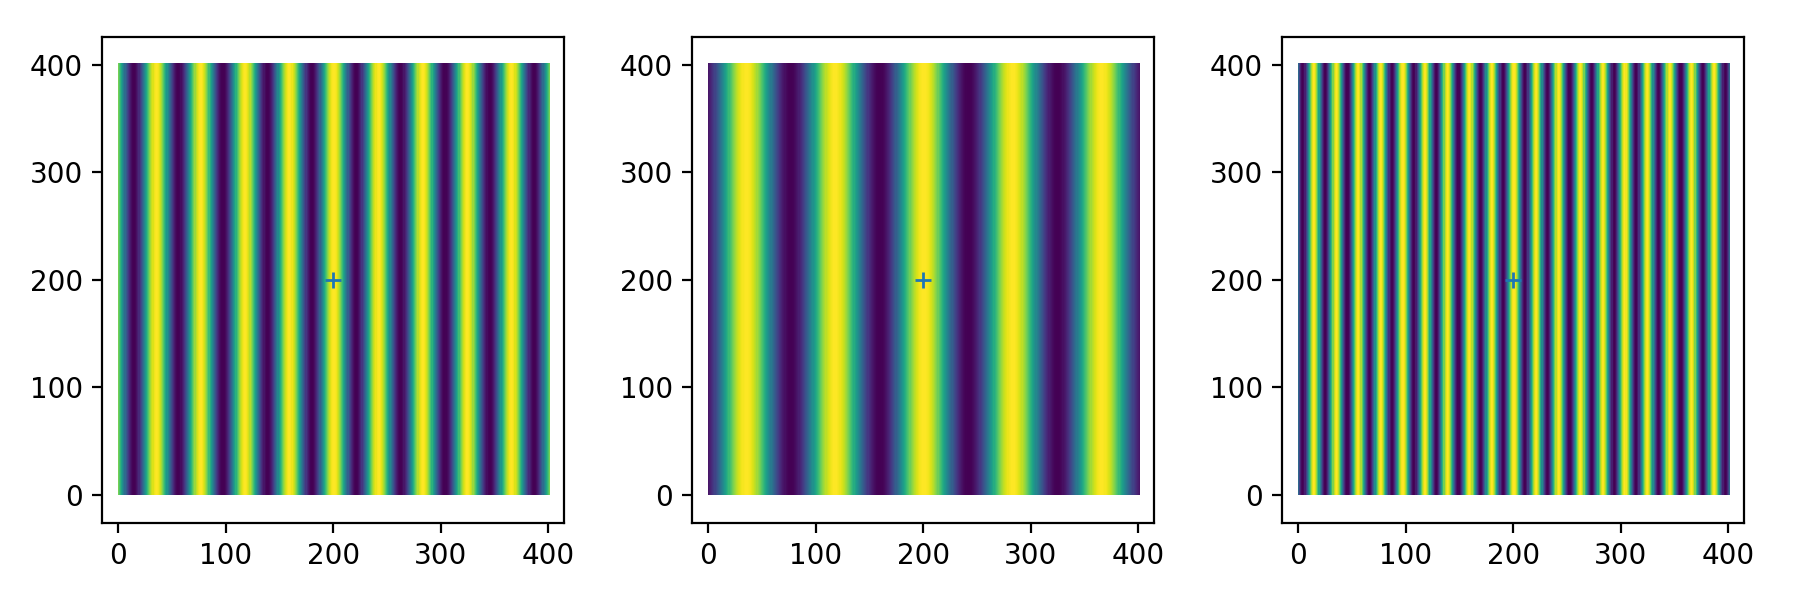

In [5]:
# show the finge pattern projected onto the sky
fig,ax = plt.subplots(1,3,figsize=(9,3))

im = fringes(np.zeros((sz,sz)),u,v,pixel_scale=pixel_scale)
ax[0].imshow(im,origin='bottom')
im = fringes(np.zeros((sz,sz)),u/2,v/2,pixel_scale=pixel_scale)
ax[1].imshow(im,origin='bottom')
im = fringes(np.zeros((sz,sz)),u*2,v*2,pixel_scale=pixel_scale)
ax[2].imshow(im,origin='bottom')

for a in ax:
    a.plot((sz-1)/2.,(sz-1)/2.,'+')
    a.axis('equal')
    
fig.tight_layout()

## Fourier transform of a binary
Create two point sources at some separation, and check whether the fringes in the FT are separated as we expect. The FFT functions used here return images with the same size as the input.

The units of the axes from the FT of an NxN image are those of the uv plane, which are normally expressed in wavelengths (e.g. $b/\lambda$). The FT frequencies are spaced by the sampling frequency $f_s$ divied by N (i.e. $c / [p N]$). This is just the inverse of the image size (in radians). So the larger the image, the smaller (lower) the minimum frequency. That is, larger images are needed to probe larger spatial scales (lower spatial frequencies).

The frequencies are normally returned with an DC component in the first pixel [0,0], positive frequency terms up to N/2 (the Nyquist frequency, $f_s/2$), and then negative frequency terms counting back down. For FTs of real valued arrays (i.e. sky images) the negative values are conjugates of the positive ones.

For a binary with separation $a$, the visibility amplitude goes to zero when the binary is separated by half the fringe spacing. This is because the fringes from the two stars are separated by $a=\lambda/(2b)$ and therefore cancel. This is said to be the resolution of the interferometer, and for example a 10m baseline at a wavelength of 1mm will (just) resolve a 10" binary.

If $a$ is in arcseconds, then the separation in uv space between visibility peaks is $c/a$. So our 10" binary gives peaks that are 20k wavelengths apart. If the wavelength is 1mm then the peaks correspond to baselines of 20m. We know that the binary is just resolved for *half* this baseline, which is consistent with what was derived above. Practically, pixels in the FT are spaced $f_s/N$ apart, so the amplitude peaks are $N p / a$ pixels apart (i.e. $c/a$ divided by $c/(PN)$).

Some explanation of the FT output:
https://www.gaussianwaves.com/2015/11/interpreting-fft-results-complex-dft-frequency-bins-and-fftshift/

<IPython.core.display.Javascript object>


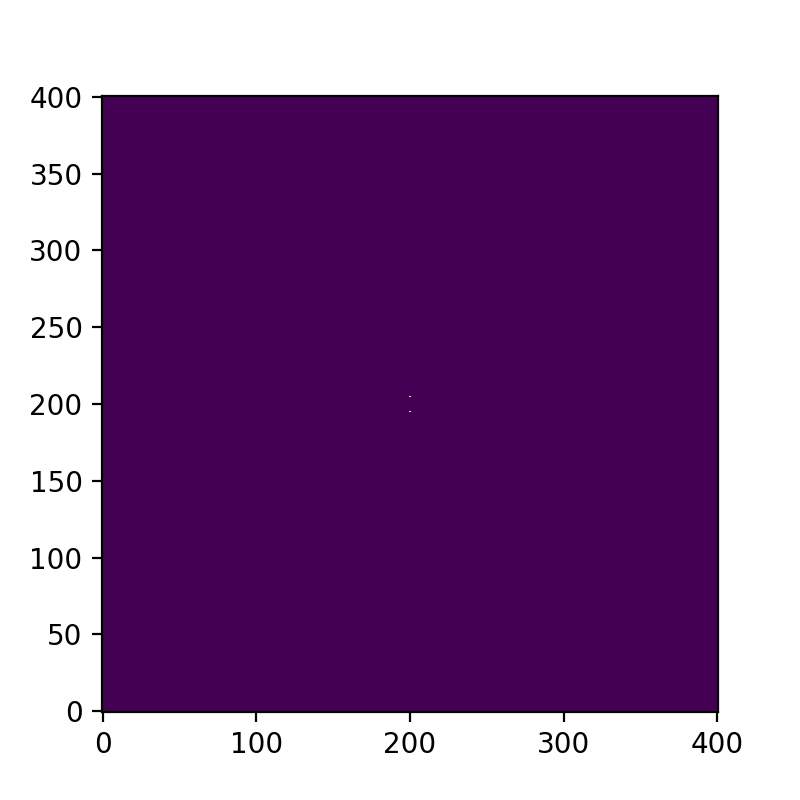

In [6]:
# make a binary with sky separation 2 x half_sep
half_sep = 5
im = np.zeros((sz,sz))
cen = int((sz)/2.)
im[cen + half_sep*np.array([-1,1]),cen*np.array([1,1])] = 1/2

fig,ax = plt.subplots(figsize=(4.,4))
ax.imshow(im,origin='bottom')

axes (lambda): 5143.760754291679  axes (m): 5.143760754291679


<IPython.core.display.Javascript object>


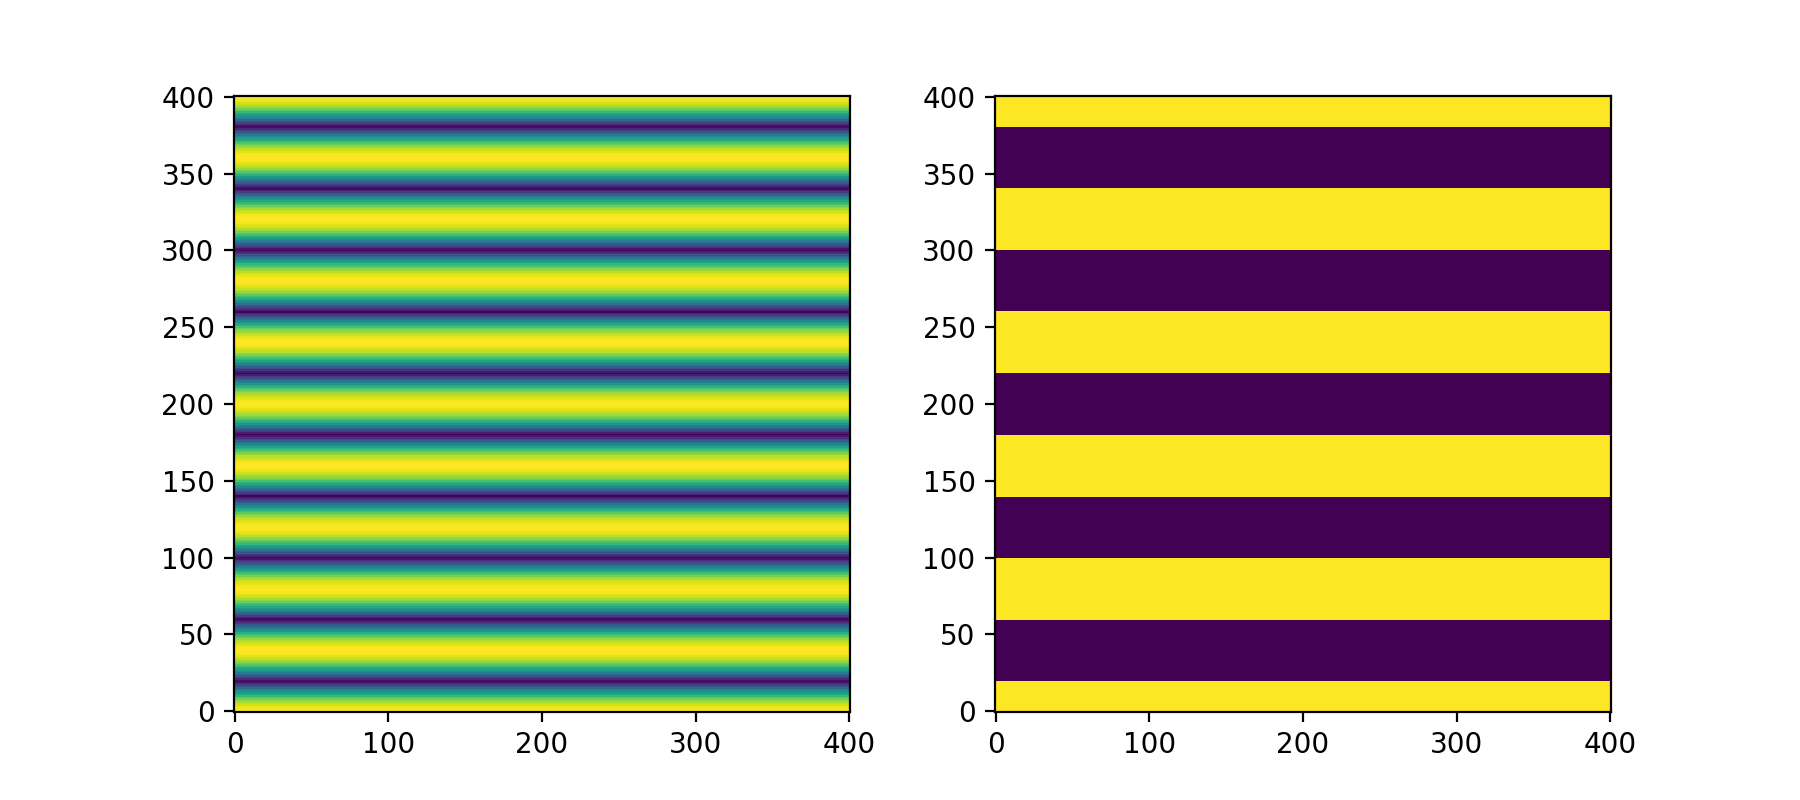

In [7]:
# see what the FT looks like, fringes should be 206265/separation wavelengths apart
uv_img = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(im)))

# fft (uv plane) axis units are sampling frequency (i.e. pixels per radian) divided 
# by number of samples (pixels in image), so multiplying by wavelengths gives the
# separation of the baseline at each uv point.
fft_units = f_samp / sz
print('axes (lambda):',fft_units,' axes (m):',fft_units*wavelength)

# plot fringes (not amplitude) and phase
fig,ax = plt.subplots(1,2,figsize=(9,4))
ax[0].imshow(np.abs(uv_img),origin='bottom')
ax[1].imshow(np.angle(uv_img),origin='bottom')

<IPython.core.display.Javascript object>


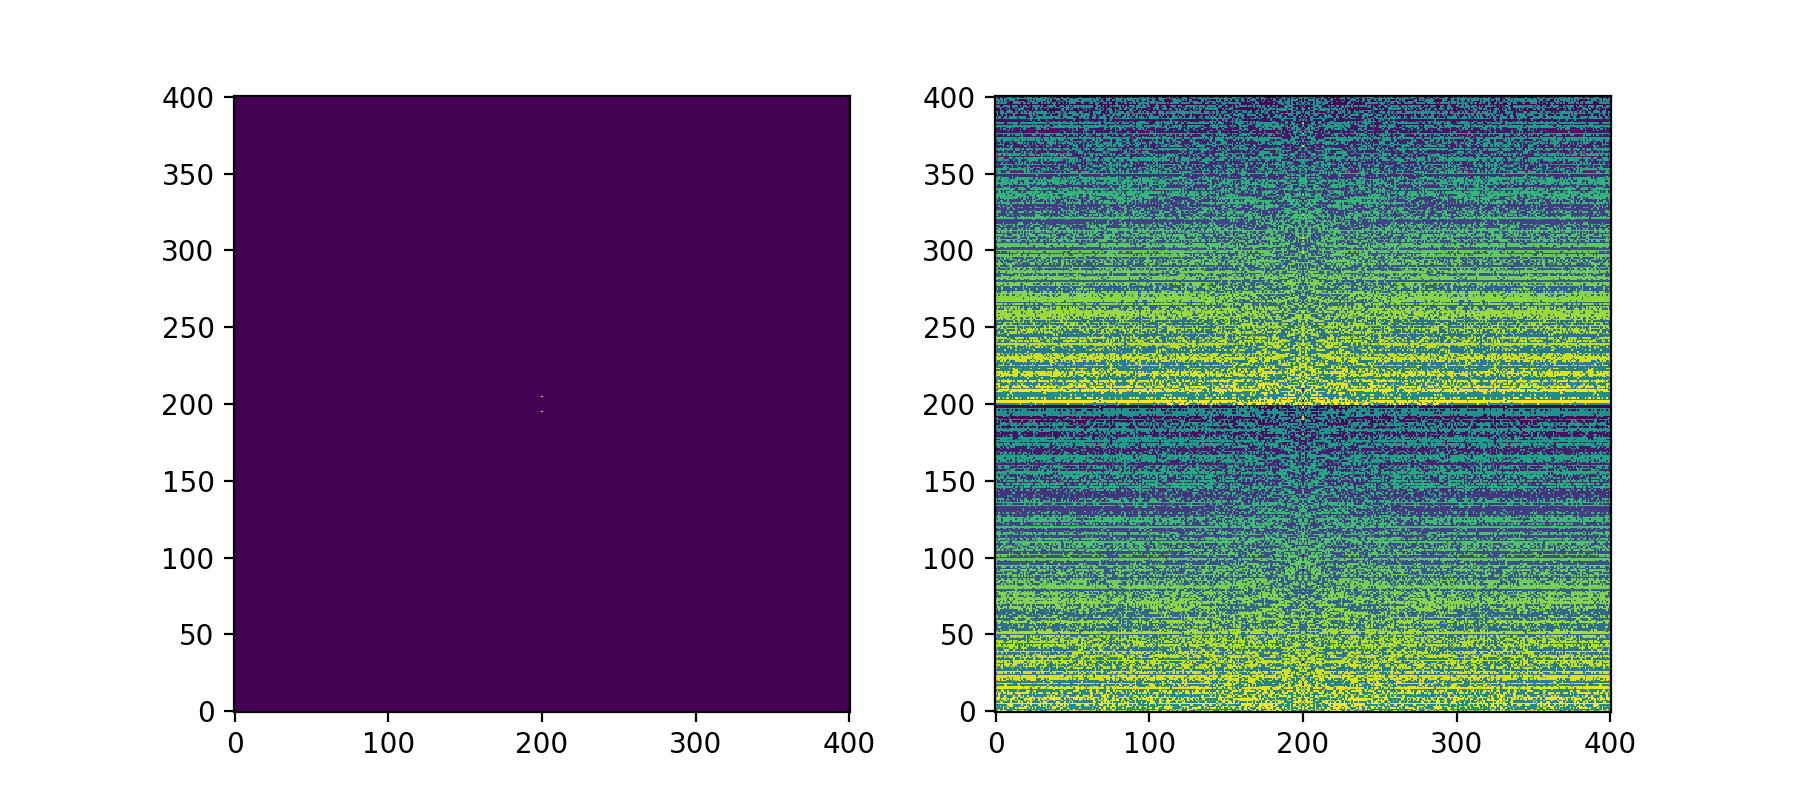

In [8]:
# and transform back as a check
im = np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(uv_img)))

# thresh = np.where(np.abs(im) < 1e-5)
# im[thresh] = 0.0

fig,ax = plt.subplots(1,2,figsize=(9,4))
ax[0].imshow(np.abs(im),origin='bottom')
ax[1].imshow(np.angle(im),origin='bottom')

## Some examples
Plot some examples of FTs.

In [9]:
def plot_fft_image(im):

    fig,ax = plt.subplots(figsize=(4.,4))
    ax.imshow(im,origin='bottom')

    # we shift first so that the center of the image is in the zeroth pixel, and thus the phase is ~0
    uv_img = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(im)))

    # we could mask the stuff around the edges of the phase plot by ignoring where the amplitude is low
    # thresh = np.where(np.abs(uv_img) < 1e-14)
    # uv_img[thresh] = 0.0

    # plot amplitude and phase
    # fig,ax = plt.subplots(figsize=(4,4))
    # ax.imshow(np.abs(uv_img),origin='bottom')
    fig,ax = plt.subplots(1,2,figsize=(9,4))
    ax[0].imshow(np.abs(uv_img),origin='bottom')
    ax[1].imshow(np.angle(uv_img),origin='bottom')

    # what is the stuff around the edges? noise at very low amplitude
    fig,ax = plt.subplots(2,figsize=(10.,4))
    ax[0].semilogy(np.abs(uv_img[:,int(sz/2)]))
    ax[1].plot(np.angle(uv_img[:,int(sz/2)]))

<IPython.core.display.Javascript object>


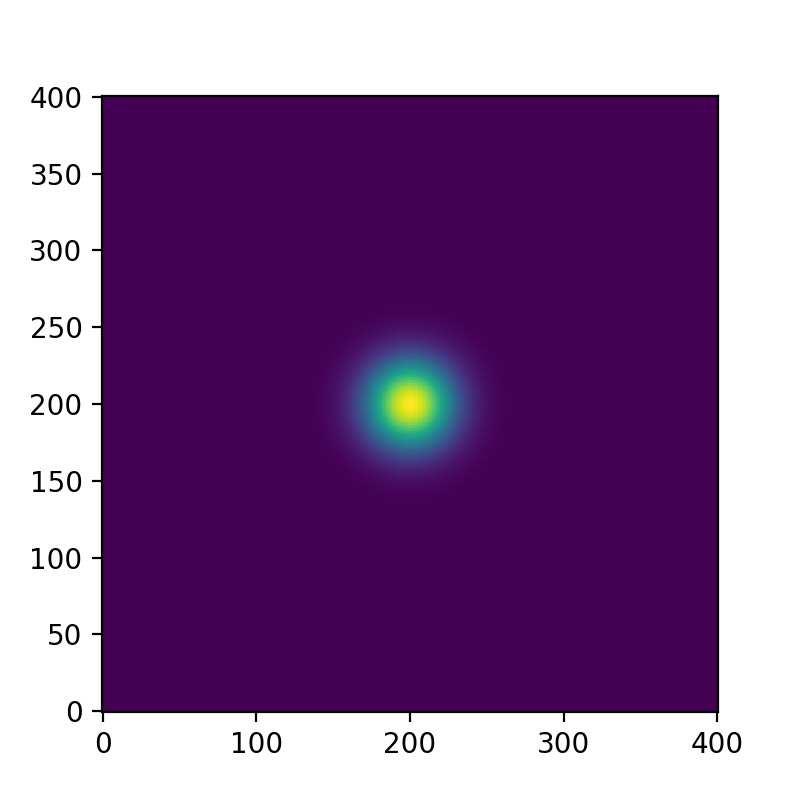

<IPython.core.display.Javascript object>


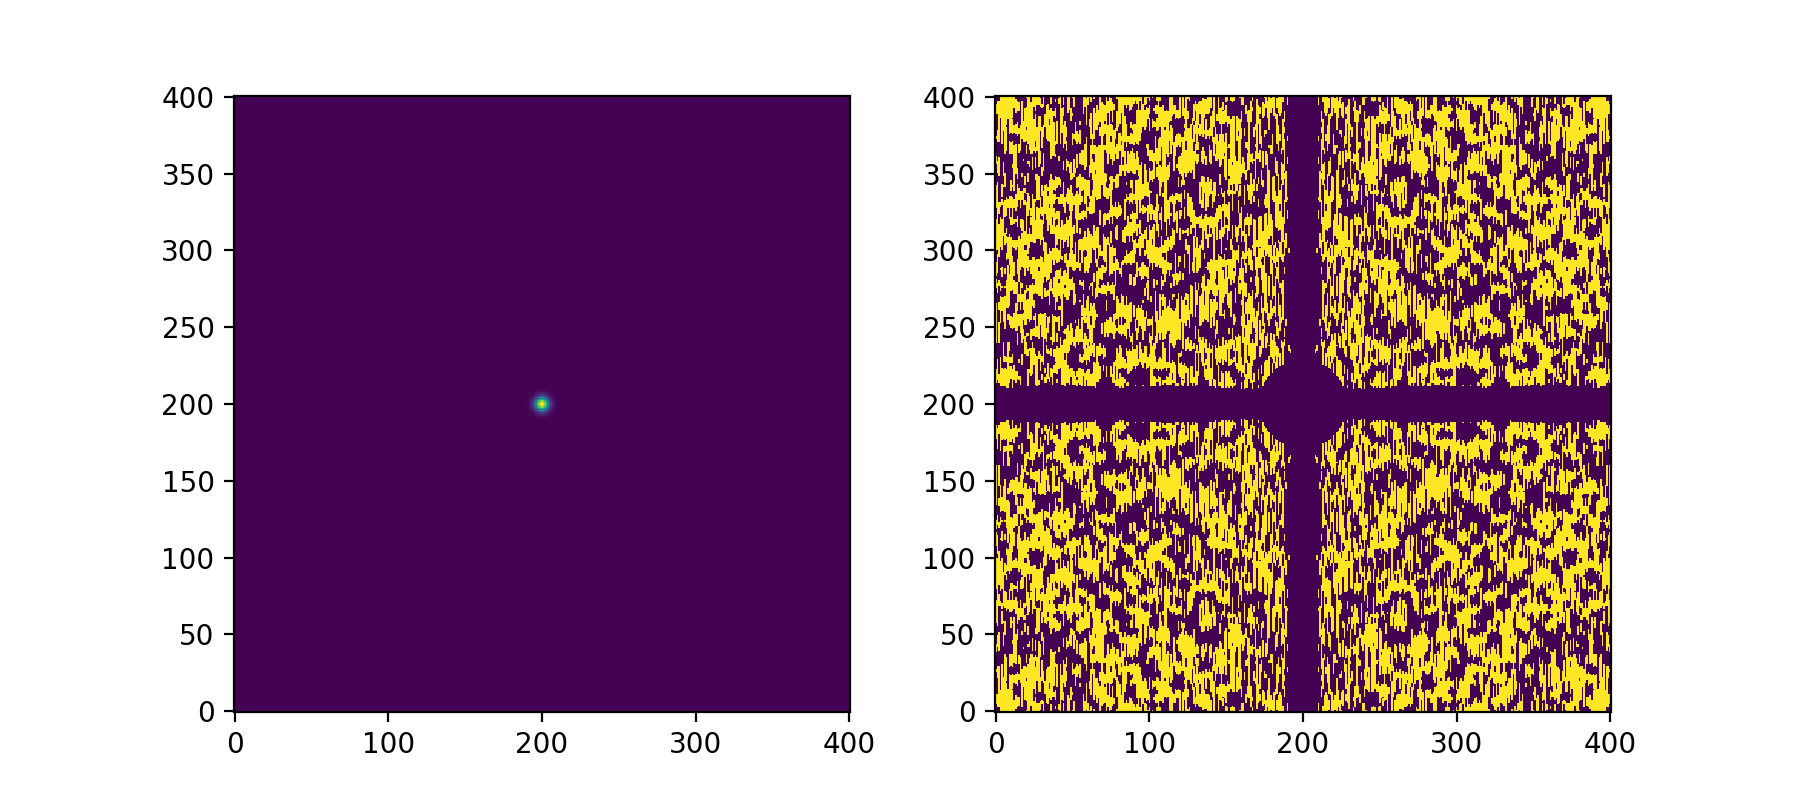

<IPython.core.display.Javascript object>


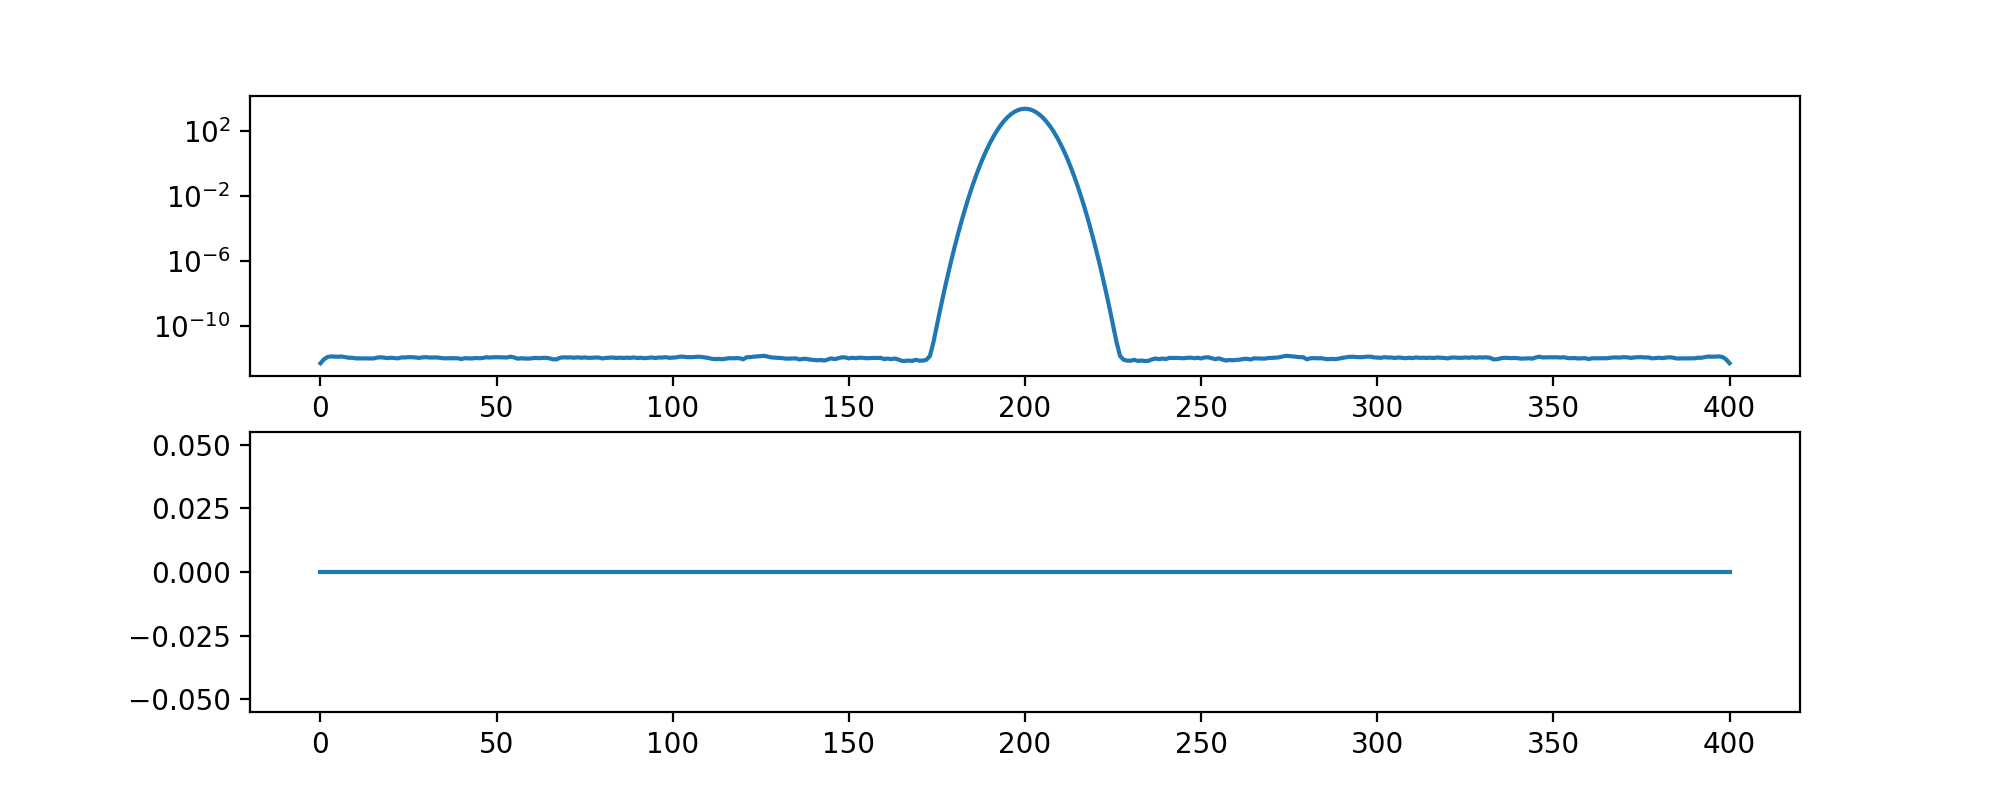

In [10]:
#  a circular Gaussian
radius = 20
im = np.zeros((sz,sz))
x = np.arange(sz) + 0.5 - sz/2.
x, y = np.meshgrid(x,x)
im = np.exp(-( x**2 + y**2 )/(2*radius**2))
plot_fft_image(im)

/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


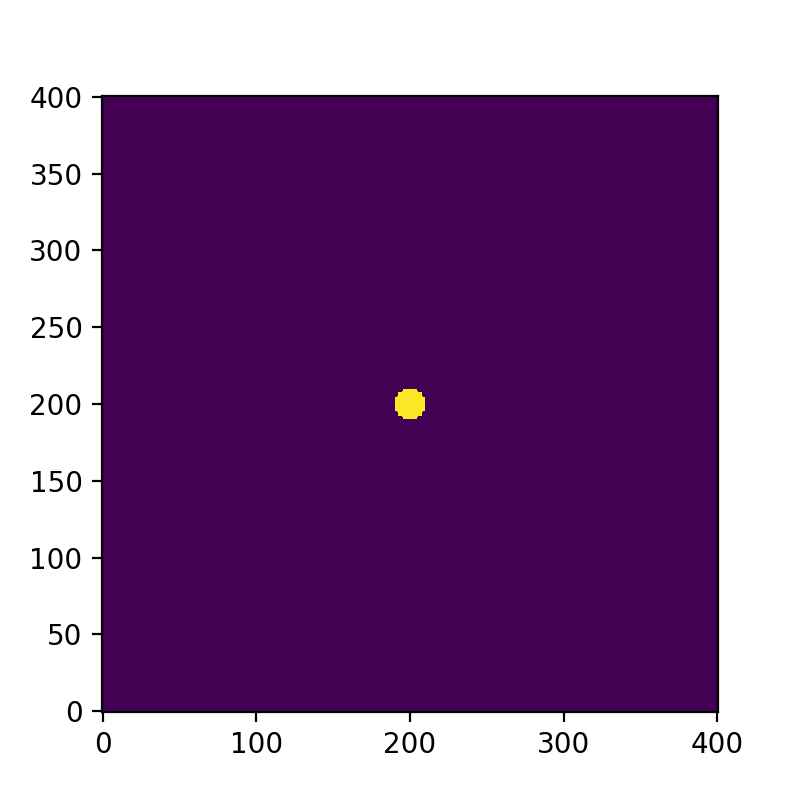

<IPython.core.display.Javascript object>


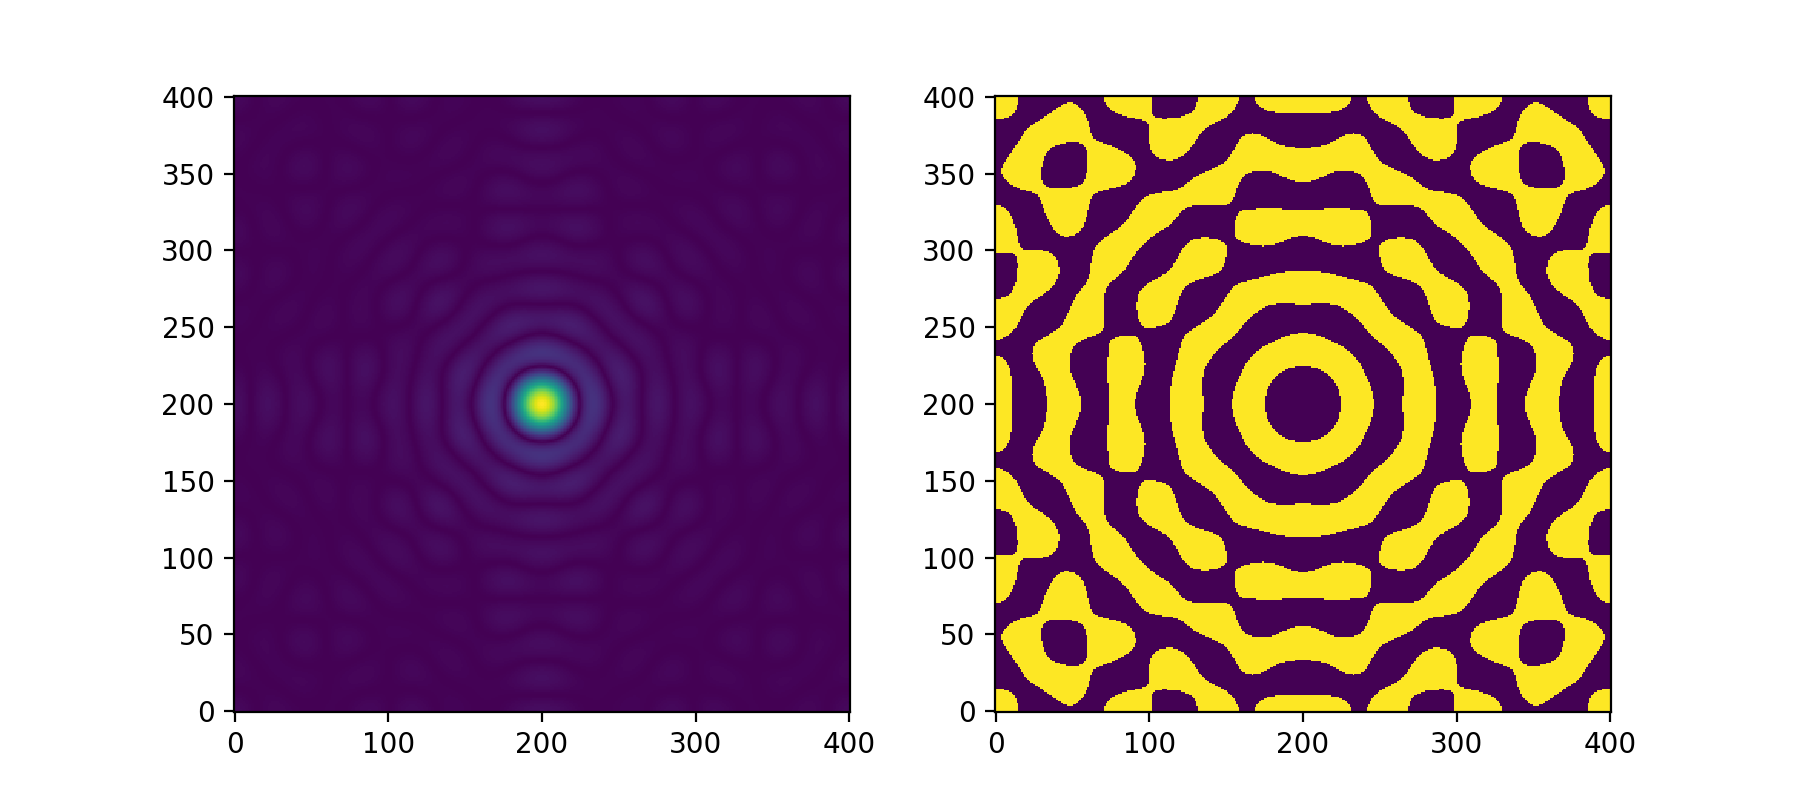

<IPython.core.display.Javascript object>


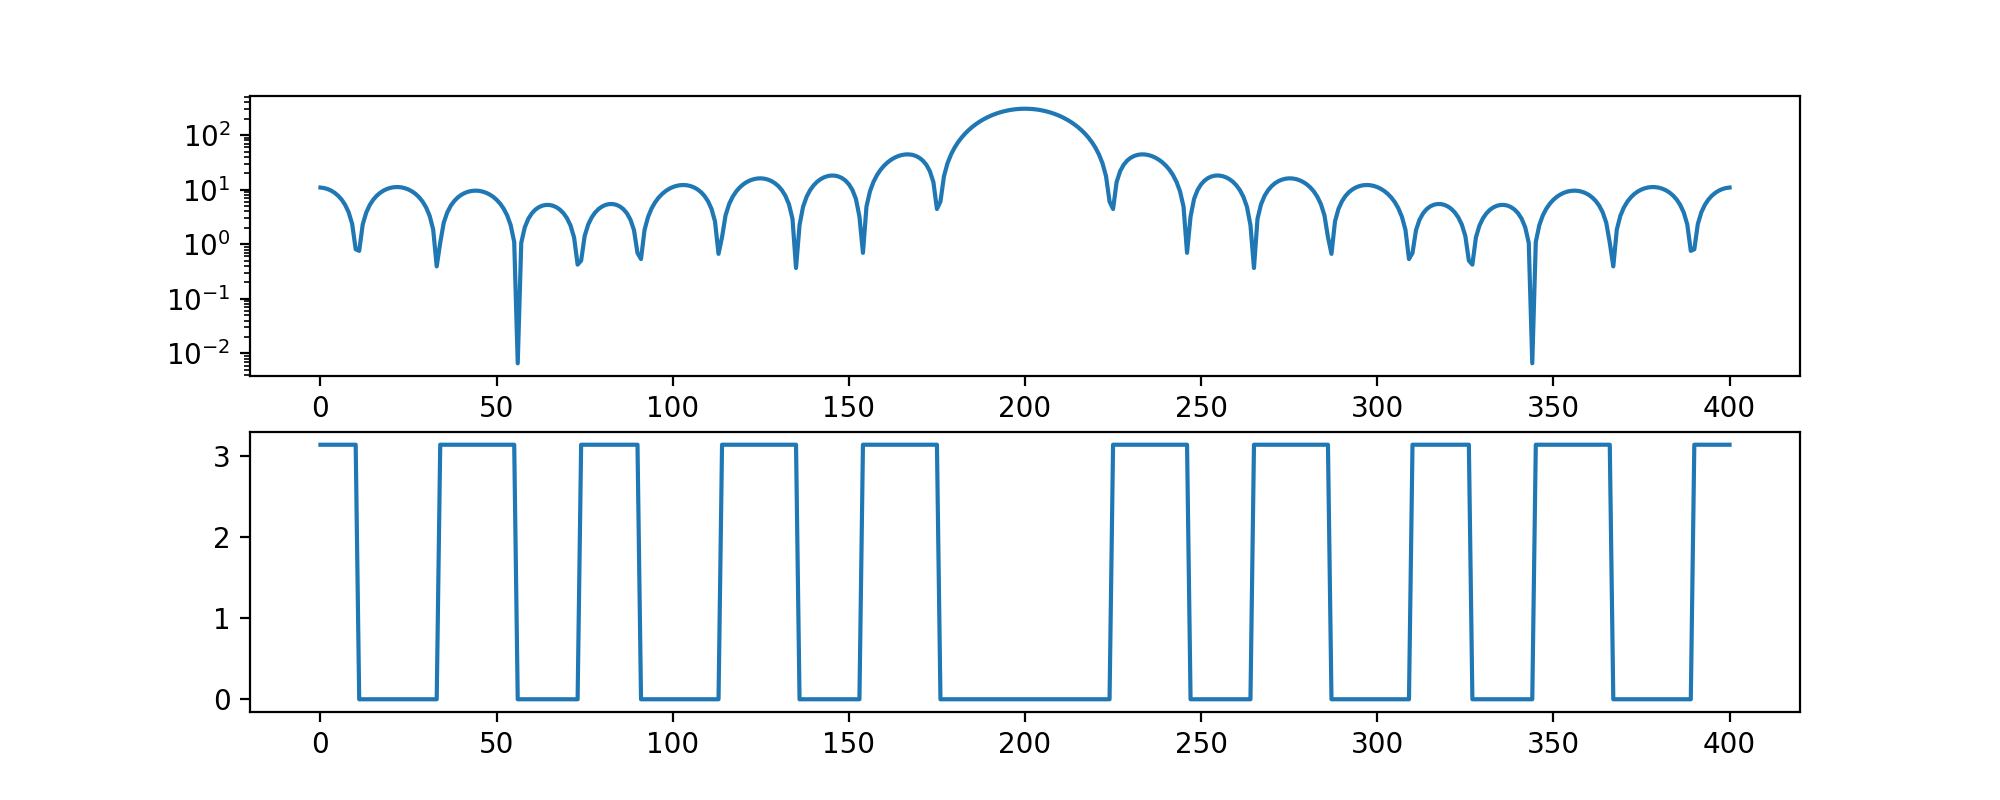

In [24]:
#  a circular disk
radius = 10
im_disk = np.zeros((sz,sz))
x = np.arange(sz) + 0.5 - sz/2.
x, y = np.meshgrid(x,x)
ok = np.where( (x**2 + y**2) < radius**2)
im_disk[ok] = 1
plot_fft_image(im_disk)

<IPython.core.display.Javascript object>


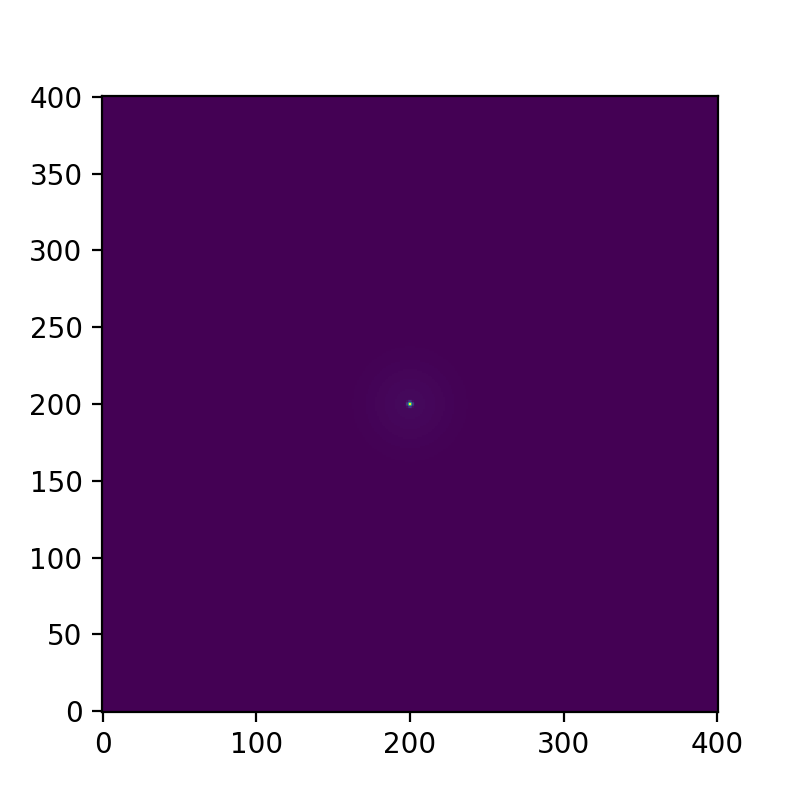

<IPython.core.display.Javascript object>


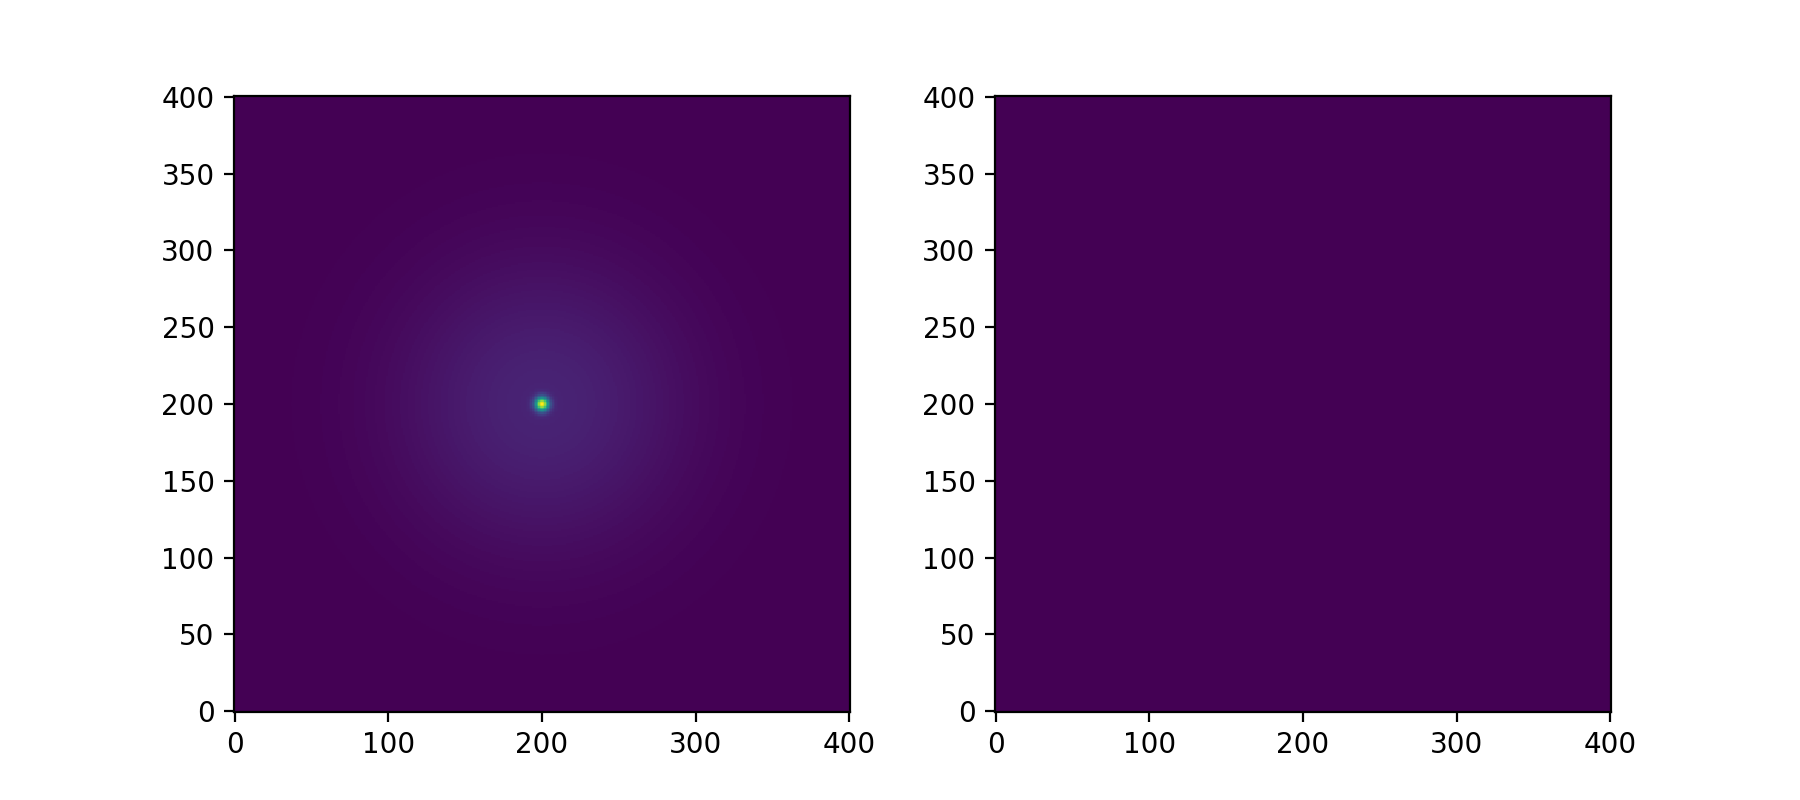

<IPython.core.display.Javascript object>


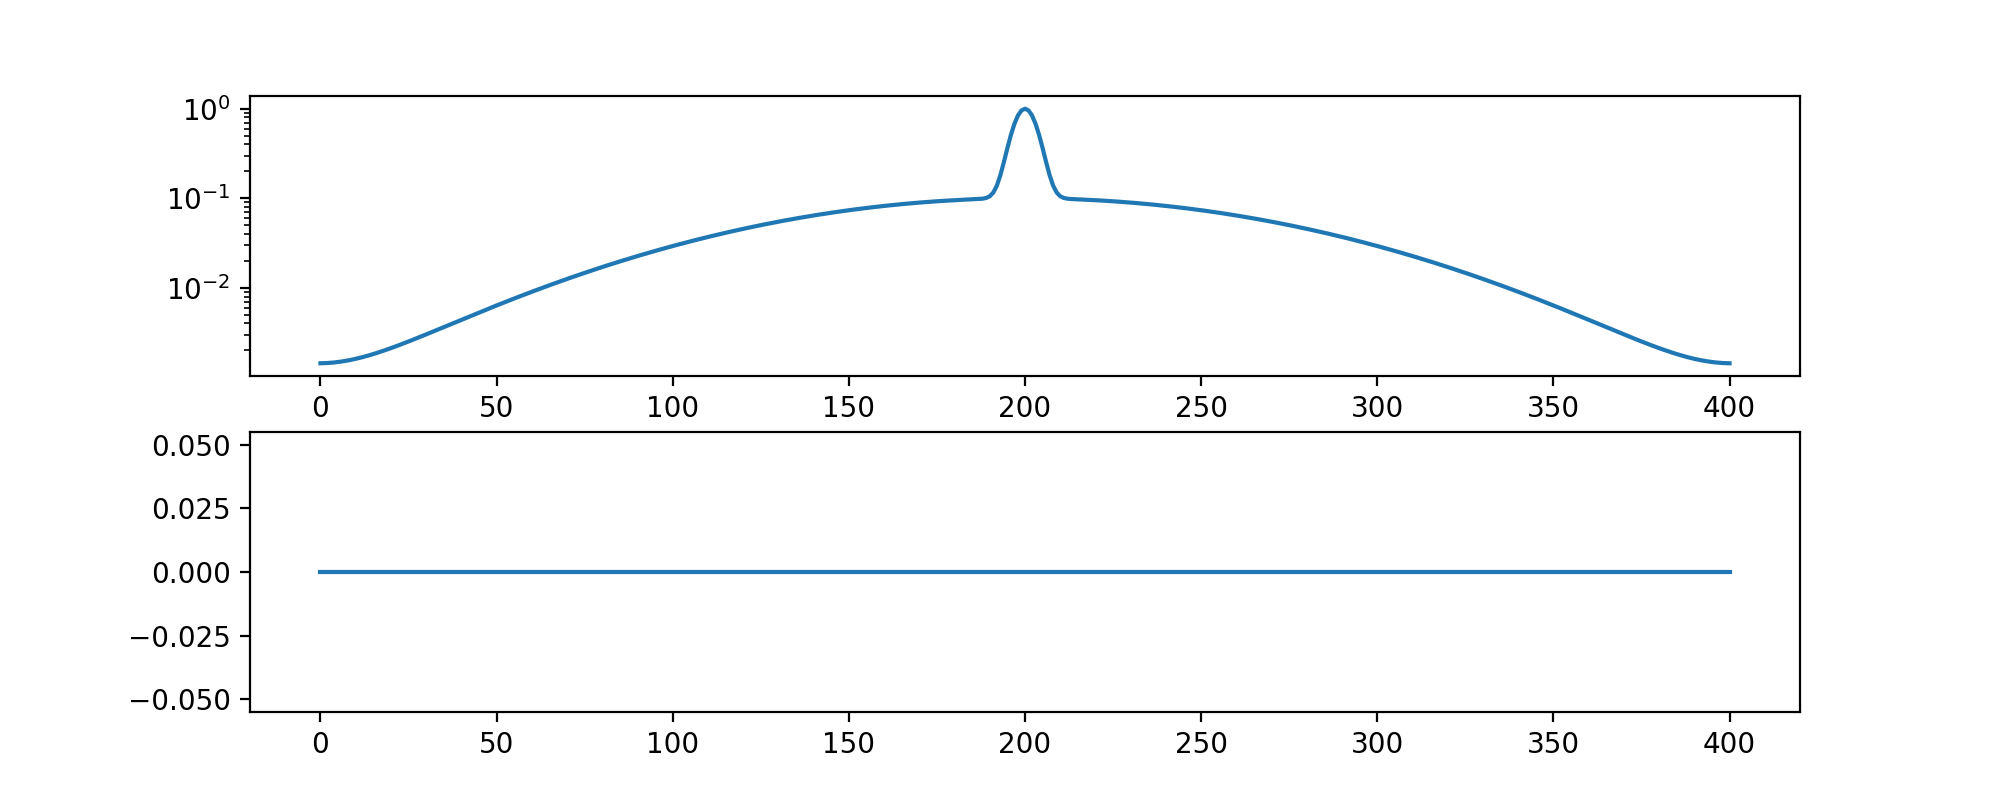

In [12]:
#  a small and large Gaussian
radius = [1,20]
im = np.zeros((sz,sz))
x = np.arange(sz) + 0.5 - sz/2.
x, y = np.meshgrid(x,x)
im1 = np.exp(-( x**2 + y**2 )/(2*radius[0]**2))
im2 = np.exp(-( x**2 + y**2 )/(2*radius[1]**2))
im = 0.1*im1/np.sum(im1) + 0.9*im2/np.sum(im2)
plot_fft_image(im)

## Filling in the fringe pattern with intermediate baselines
A single baseline is only specific where the primary beam is on the sky, but otherwise cannot localise the source very well. This problem can be alleviated by adding intermediate baselines.

16.666666666666664
33.33333333333333


<IPython.core.display.Javascript object>


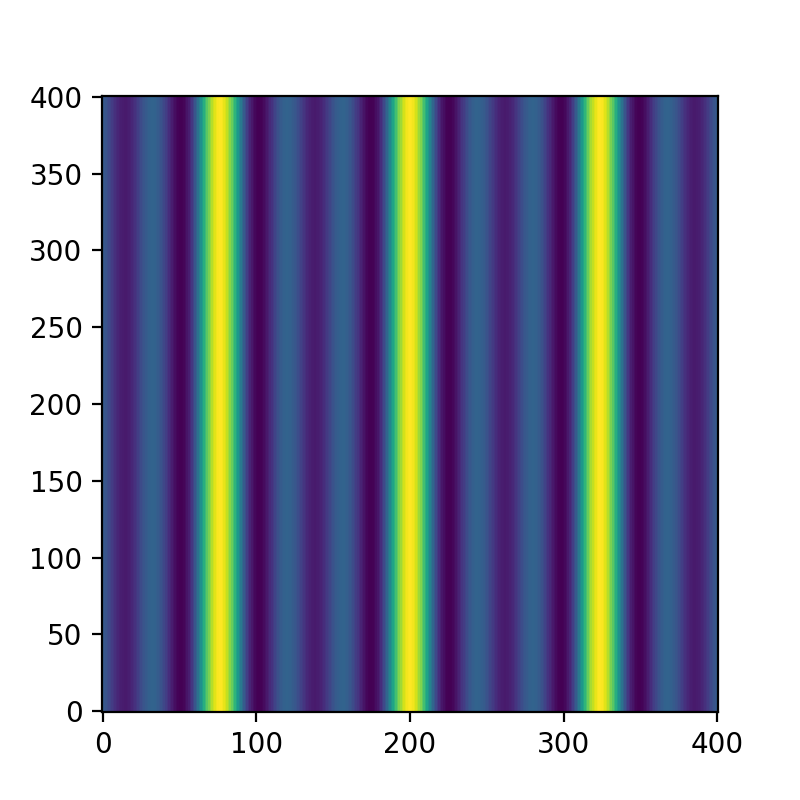

In [13]:
# show the effect of filling in intermediate baselines, here we add baselines
nb = 3 # to be realistic this needs to be (n^2-n)/2 where n is an integer (i.e. 1,3,6)
im = fringes(np.zeros((sz,sz)),u,v,pixel_scale=pixel_scale)
for f in np.arange(nb-1)+1:
    print(f/nb*b)
    im += fringes(np.zeros((sz,sz)),f*u/nb,f*v/nb,pixel_scale=pixel_scale)

fig,ax = plt.subplots(figsize=(4.,4))
ax.imshow(im,origin='bottom')

axes (lambda): 5143.760754291679  axes (m): 5.143760754291679


<IPython.core.display.Javascript object>


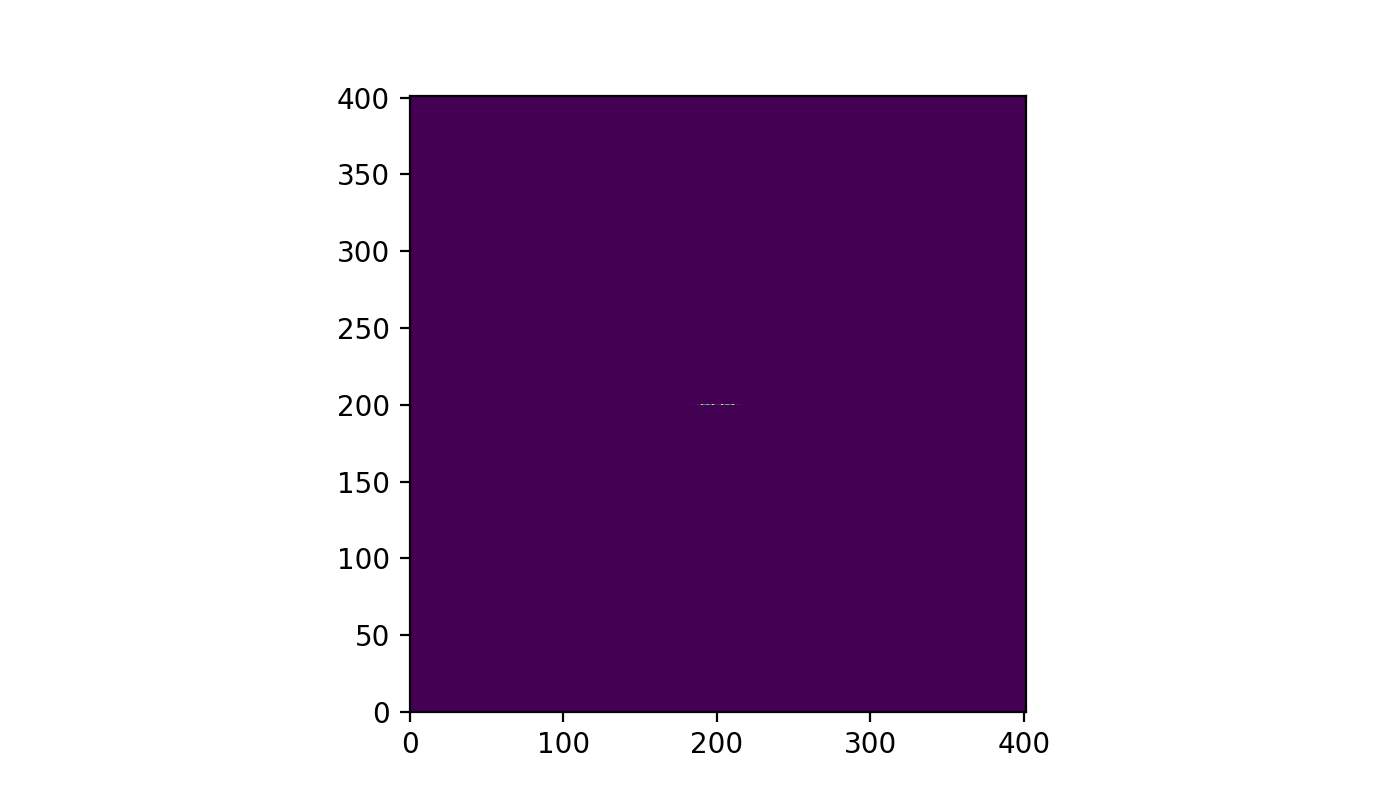

(0, 401)

In [14]:
# turn these back into baselines
uv_cov = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(im)))

# fft units are sampling frequency (i.e. pixels per radian) divided by number of samples
fft_units = f_samp / sz
print('axes (lambda):',fft_units,' axes (m):',fft_units*wavelength)

# uv_cov[0,0] = 0
fig,ax = plt.subplots(figsize=(7,4))
ax.imshow(np.abs(uv_cov),origin='bottom')
tix = np.round( (np.arange(0,uv_cov.shape[0],25))*fft_units )
# ax.set_yticklabels(tix)
tix = np.round( (np.arange(0,uv_cov.shape[0],50))*fft_units )
# ax.set_xticklabels(tix)
ax.set_ylim(0,sz)
ax.set_xlim(0,sz)

## Add yet more baselines

<IPython.core.display.Javascript object>


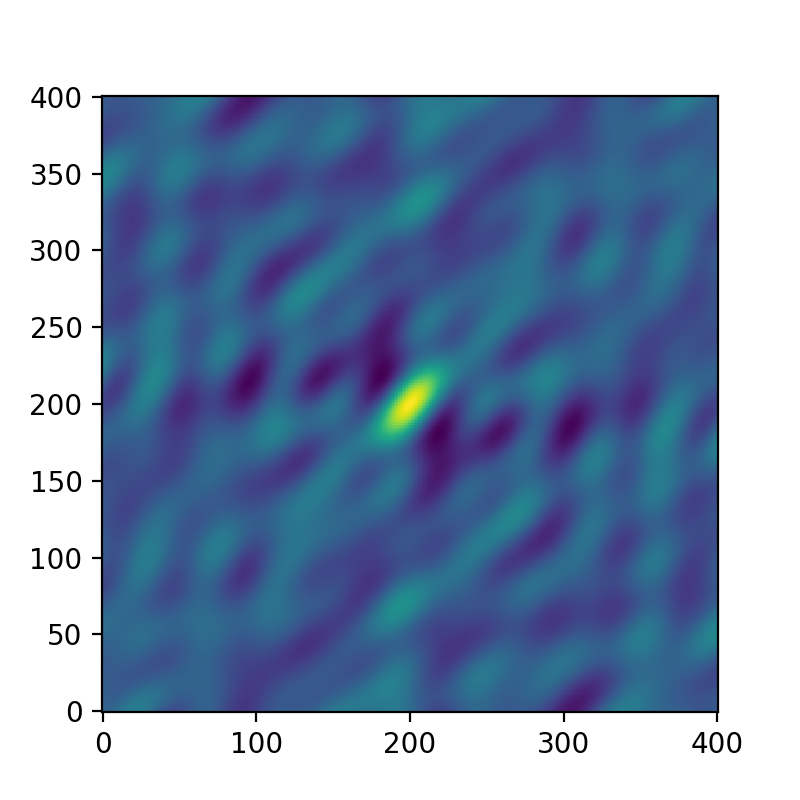

In [15]:
# extend this to a 2d array, this way is unrealistic of course
im =  fringes(np.zeros((sz,sz)),u,v,pixel_scale=pixel_scale)
for i in range(50):
    x,y = np.random.uniform(size=2)
    im += fringes(np.zeros((sz,sz)),uv*x,uv*y,pixel_scale=pixel_scale)

fig,ax = plt.subplots(figsize=(4.,4))
ax.imshow(im,origin='bottom')

# Aperture synthesis
Move the baselines as the Earth rotates. Here we assume we're at the North or South pole for simplicity.

In [16]:
# mostly copied from pynterferometer
# http://www.jb.man.ac.uk/pynterferometer/
def get_uv(x,y,hangles=[0.0],dec=90):
    '''Get the uv coordinates and mask for an observation.
    
    The coordinates from 1999ASPC..180.....T are assumed. This
    places X along a line pointing towards the meridian and Y
    to the East, so for HA=0 separations between antennas in the
    X direction convert to v in the uv plane.
    
    Parameters
    ----------
    
    x : array, list
        List of antenna x positions.
    y : array, list
        List of antenna y positions.
    hangles : list, array
        List of hour angles in degrees.
    dec : float
        Declination of the pointing direction.
        
    Returns
    -------
    u : 1d array
        Array of u coordinates in wavelengths.
    v : 1d array
        Array of v coordinates in wavelengths.
    uv : 2d array
        Mask of uv points, inverse FT of this is the dirty beam.
    '''
    
    sin_dec = np.sin(np.deg2rad(dec))

    umax = f_samp # size of the uv image in 1/rad
    vmax = f_samp
    pix_to_uv = f_samp / sz * pixel_scale

    x = np.array(x)
    y = np.array(y)
    ha_range = np.array(hangles)

    # fill baselines
    xx,yy = np.meshgrid(x,y)
    lx = xx.T - xx
    ly = yy - yy.T
            
    # compute uv points
    full_re_u = np.array([])
    full_re_v = np.array([])
    for ha in ha_range:
        sin_ha = np.sin((ha * np.pi)/ 180.)
        cos_ha = np.cos((ha * np.pi)/ 180.)
        u = np.ceil(( (lx*sin_ha) + (ly*cos_ha) ) / wavelength)                   # u values including ha
        v = np.ceil(( (-1.*lx*sin_dec*cos_ha) + (ly*sin_dec*sin_ha) )/wavelength) # v values
         #reshape u into linear form
        re_u = np.reshape(u,(len(x)**2),order='F')
        re_v = np.reshape(v,(len(y)**2),order='F')
        full_re_u = np.append(full_re_u,re_u)
        full_re_v = np.append(full_re_v,re_v)

    # remove zero baselines
    ok = (full_re_u != 0) & (full_re_v != 0)
    full_re_u = full_re_u[ok]
    full_re_v = full_re_v[ok]
        
    # rescale to uv image scale
    full_re_uimg = (full_re_u/umax)*sz#pix_to_uv
    full_re_vimg = (full_re_v/vmax)*sz#pix_to_uv

    # matrix same size as in image for multiplying with fft of true sky image
    obs_uv_matrix=np.zeros((sz,sz))
    for k in range(len(full_re_uimg)):
        int_u = int(full_re_uimg[k])
        int_v = int(full_re_vimg[k])
        obs_uv_matrix[int_v,int_u] = 1.0 # swap u/v

    obs_uv_matrix[0,0] = 0
    
    # shift to put lowest frequencies in the middle
    obs_uv_matrix = np.fft.fftshift(obs_uv_matrix)

    return full_re_u,full_re_v,obs_uv_matrix

/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


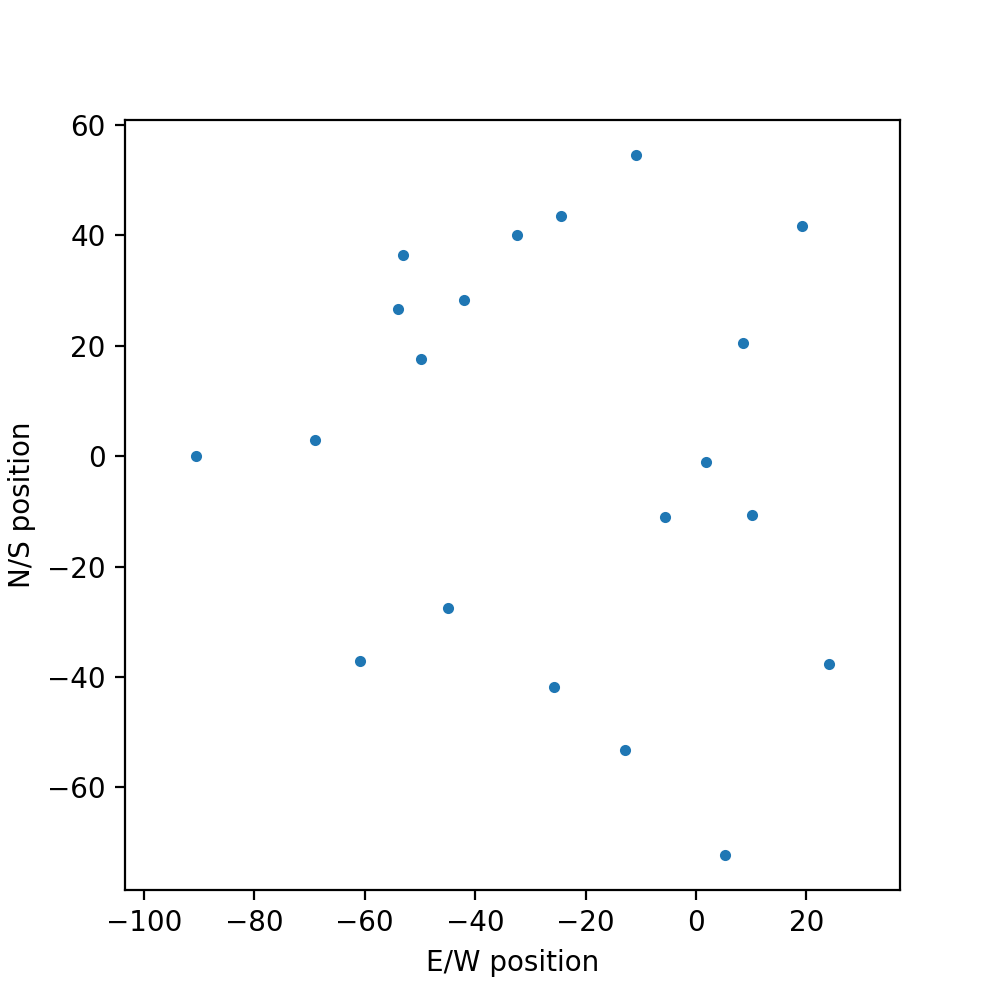

<IPython.core.display.Javascript object>


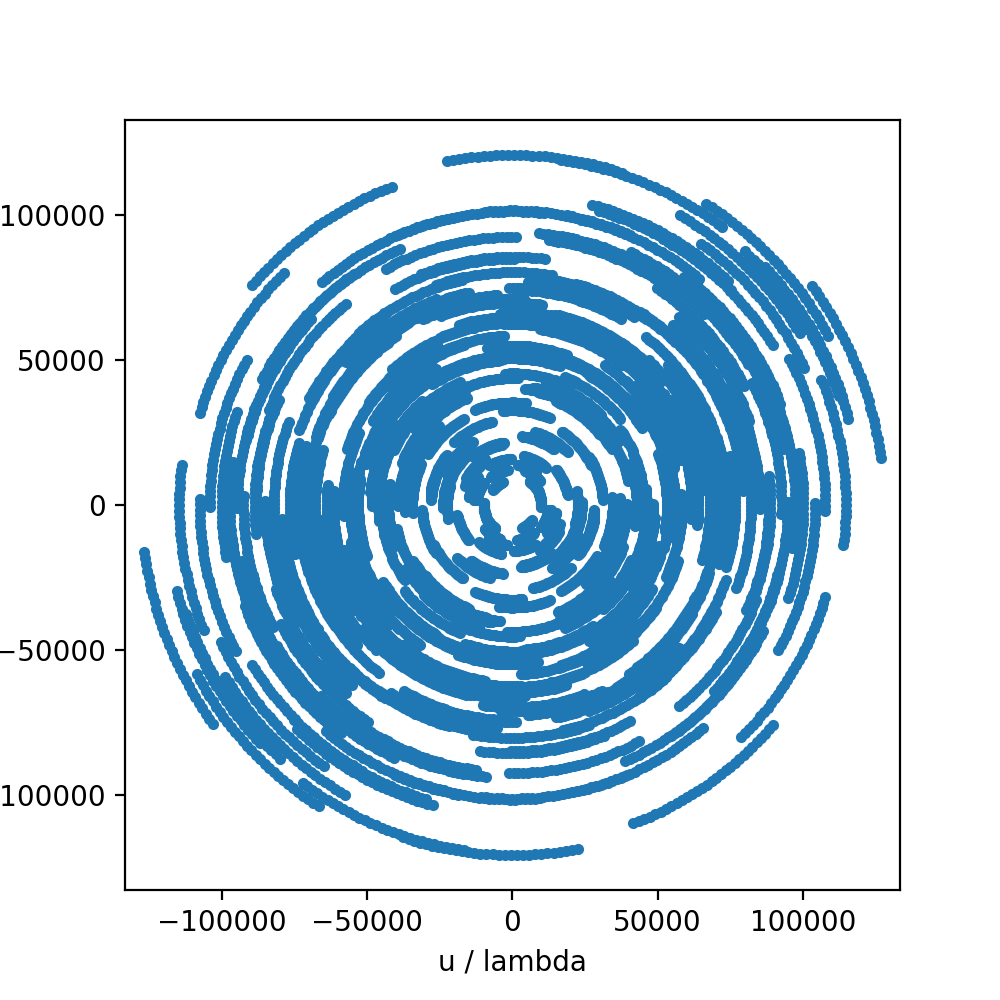

<IPython.core.display.Javascript object>


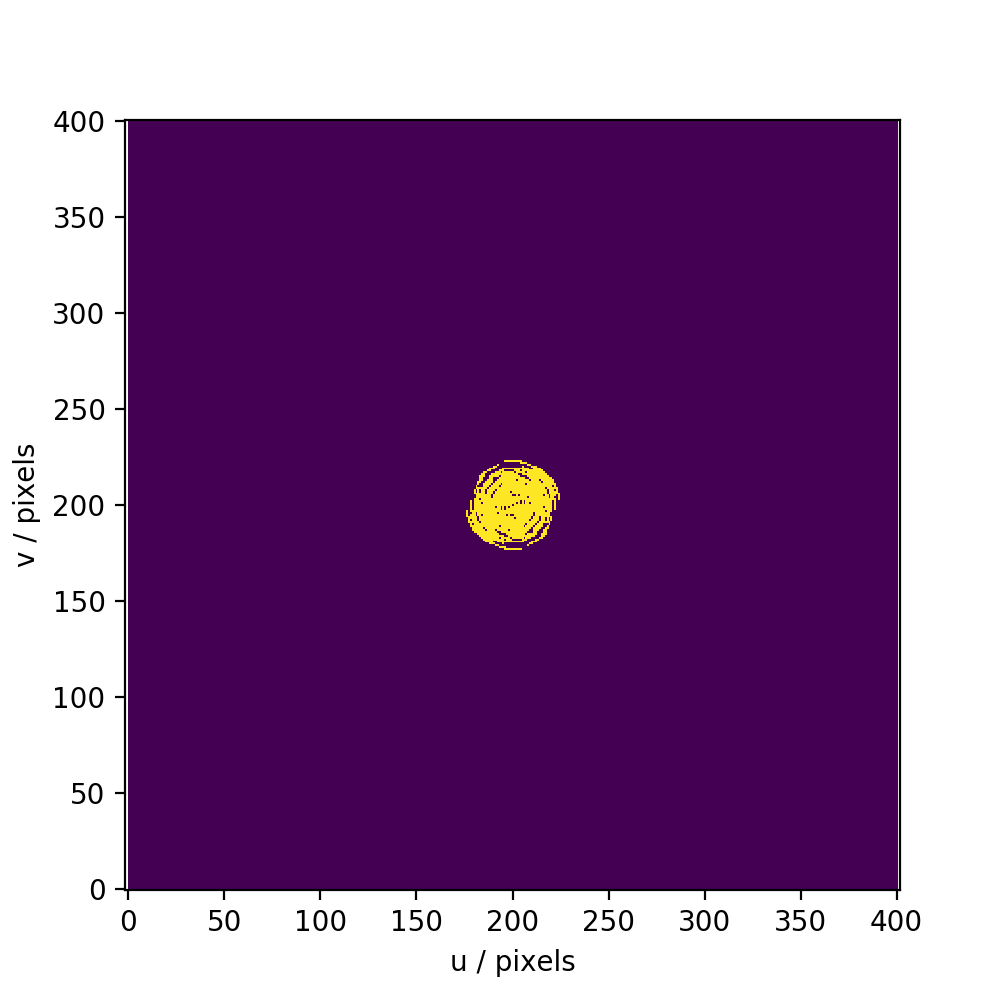

<IPython.core.display.Javascript object>


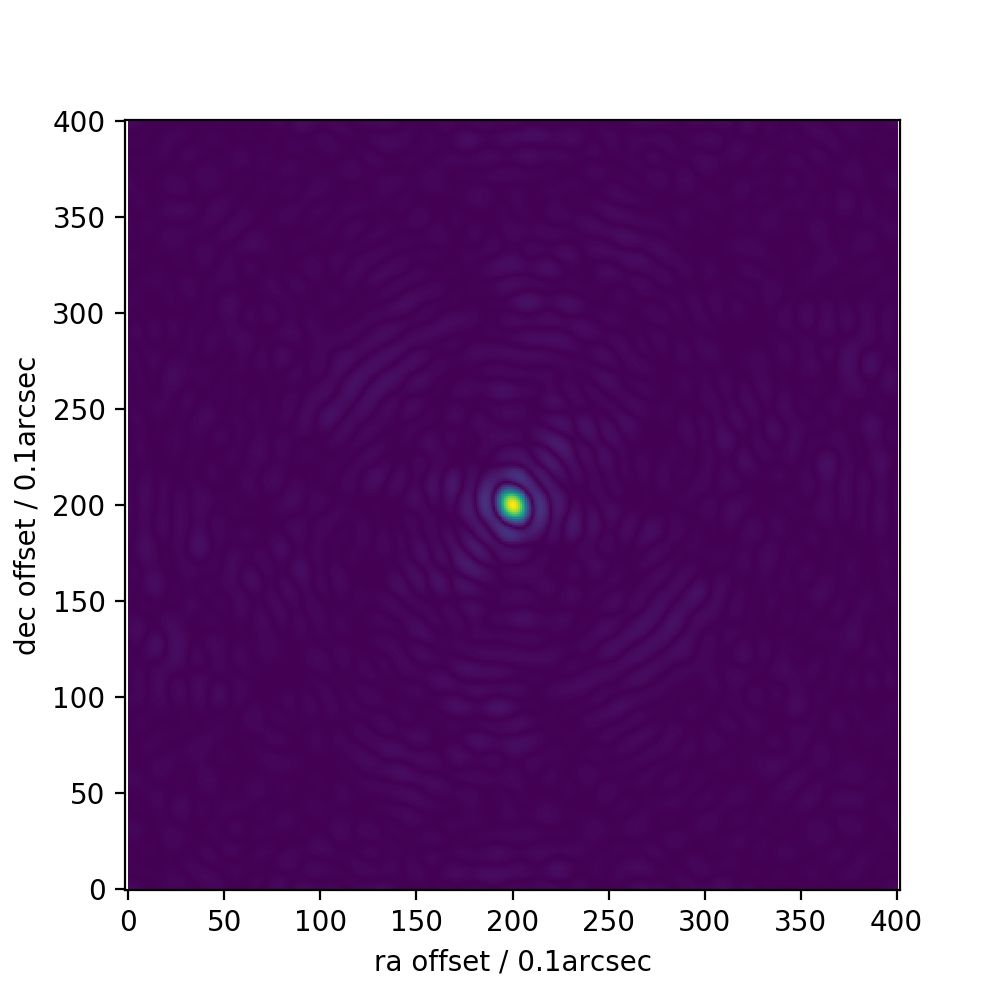

(-0.5, 400.5, -0.5, 400.5)

In [64]:
# an example with rotation
n_antenna = 20
pos = np.random.uniform(100,size=n_antenna) * np.exp(1j * np.random.uniform(2*np.pi,size=n_antenna))
x = np.real(pos)
y = np.imag(pos)
ha_range = np.arange(0,30,1)

uu,vv,obs_uv_matrix = get_uv(x,y,hangles=ha_range,dec=90)
# the dirty beam
db = np.fft.fftshift(np.fft.ifft2((obs_uv_matrix)))

# show the uv coverage and the inverse FT (the dirty beam)
fig,ax = plt.subplots(figsize=(5,5))
ax.plot(x,y,'.')
ax.set_xlabel('E/W position')
ax.set_ylabel('N/S position')
ax.axis('equal')
fig,ax = plt.subplots(figsize=(5,5))
ax.plot(uu,vv,'.')
ax.set_xlabel('u / lambda')
ax.set_ylabel('v / lambda')
ax.axis('equal')
fig,ax = plt.subplots(figsize=(5,5))
ax.imshow(obs_uv_matrix,origin='bottom')
ax.set_xlabel('u / pixels'.format(pixel_scale))
ax.set_ylabel('v / pixels'.format(pixel_scale))
ax.axis('equal')
fig,ax = plt.subplots(figsize=(5,5))
ax.imshow(np.abs(db),origin='bottom')
ax.set_xlabel('ra offset / {}arcsec'.format(pixel_scale))
ax.set_ylabel('dec offset / {}arcsec'.format(pixel_scale))
ax.axis('equal')

/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


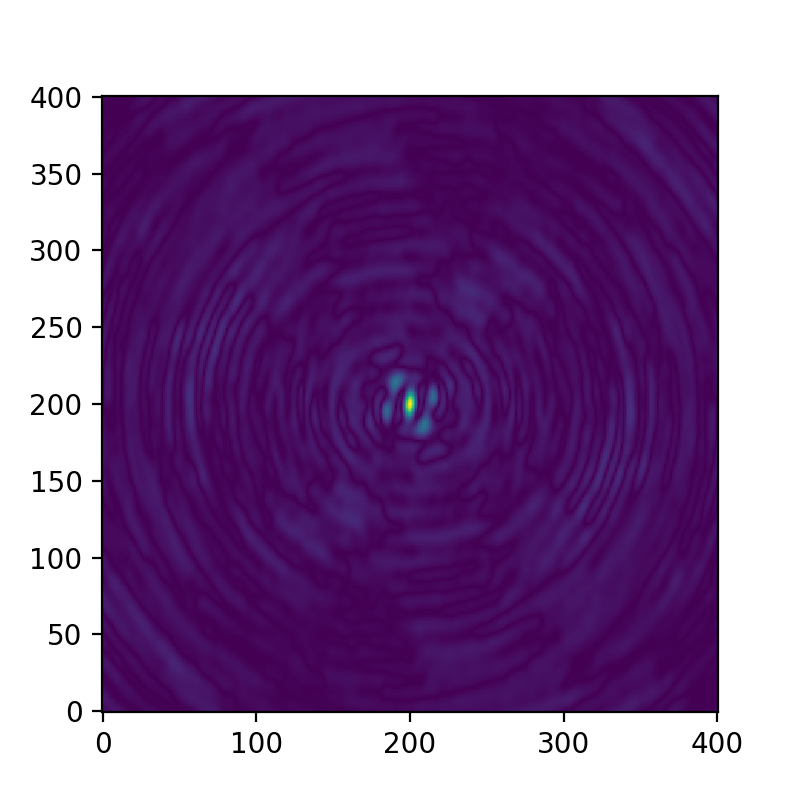

In [42]:
# get the same result by summing fringes, differences may appear
# compared to above if uv matrix isn't well enough sampled
im =  np.zeros((sz,sz))
for x,y in zip(uu,vv):
    im += fringes(np.zeros((sz,sz)),-x,y,pixel_scale=pixel_scale)

fig,ax = plt.subplots(figsize=(4,4))
ax.imshow(np.abs(im),origin='bottom')

# Image something simple

/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


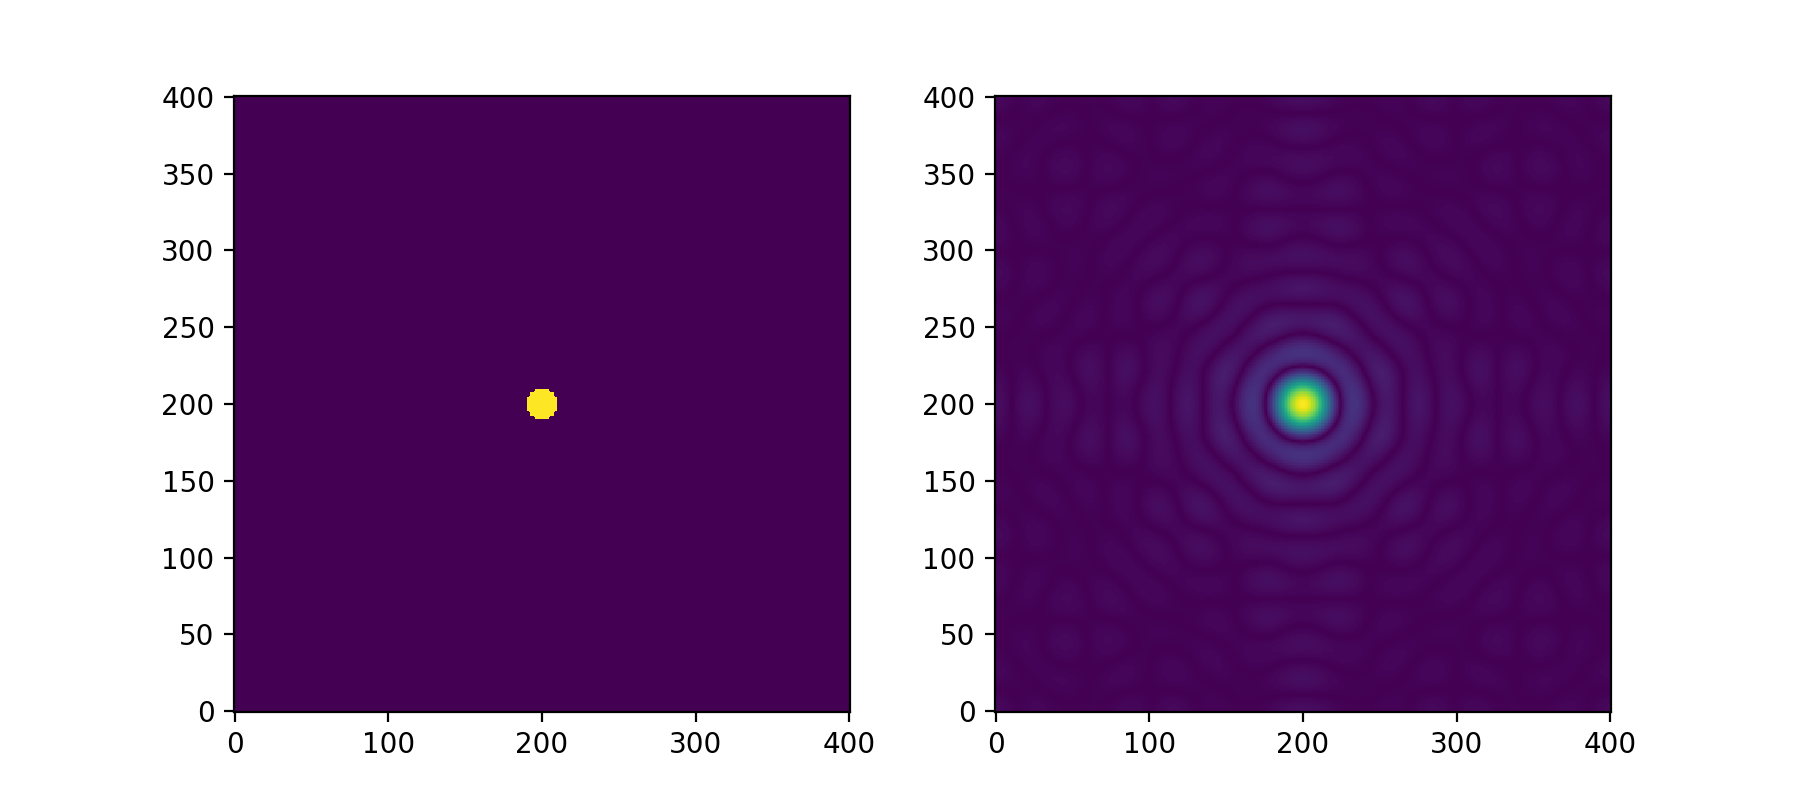

<IPython.core.display.Javascript object>


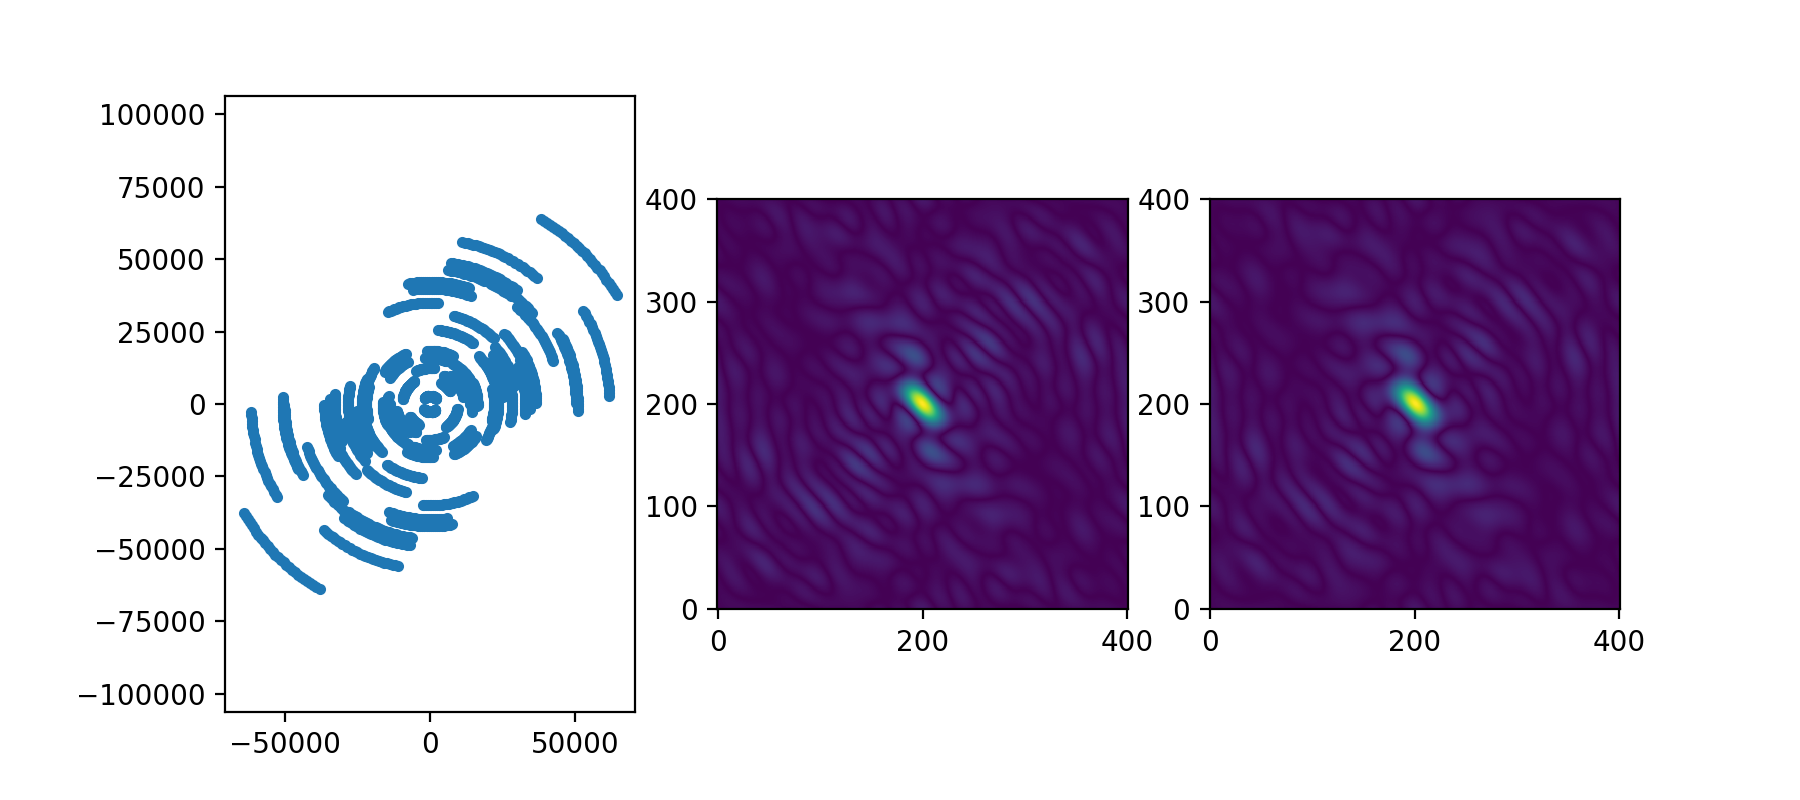

In [58]:
im = im_disk
ft = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(im)))

newim = np.fft.fftshift(np.fft.ifft2((obs_uv_matrix * ft)))

fig,ax = plt.subplots(1,2,figsize=(9,4))
ax[0].imshow(im,origin='bottom')
ax[1].imshow(np.abs(ft),origin='bottom')

fig,ax = plt.subplots(1,3,figsize=(9,4))
ax[0].plot(uu, vv, '.')
ax[0].axis('equal')
ax[1].imshow(np.abs(db), origin='bottom')
ax[2].imshow(np.abs(newim),origin='bottom')

# Image something
Load a real image, take the FT to get the visibilities, multiply these by the uv coverage, and inverse FT back to get what we'd see with our interferometer.

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


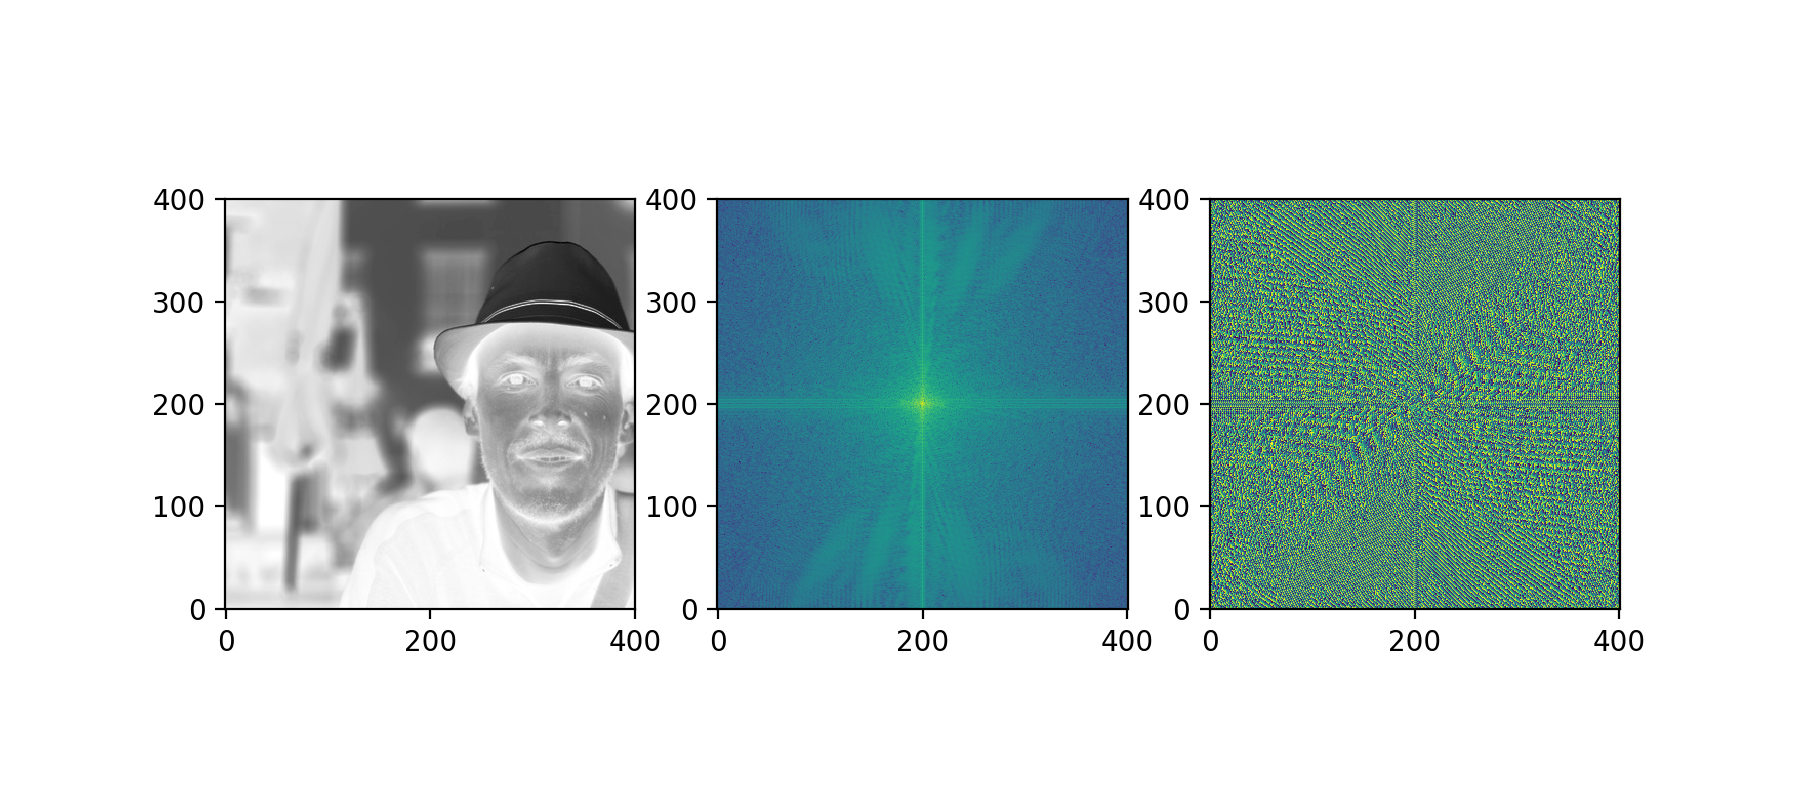

In [62]:
me = scipy.ndimage.imread('/Users/grant/Dropbox/Photos/me/grantkennedy.jpg',flatten=True)
# im = np.flipud(scipy.misc.imresize(im,(sz,sz)))
me = np.flipud(me[:sz,:sz])
ft = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(me)))

fig,ax = plt.subplots(1,3,figsize=(9,4))
ax[0].imshow(me,origin='bottom', cmap='Greys')
ax[1].imshow(np.log(np.abs(ft)),origin='bottom')
ax[2].imshow(np.angle(ft),origin='bottom')

/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


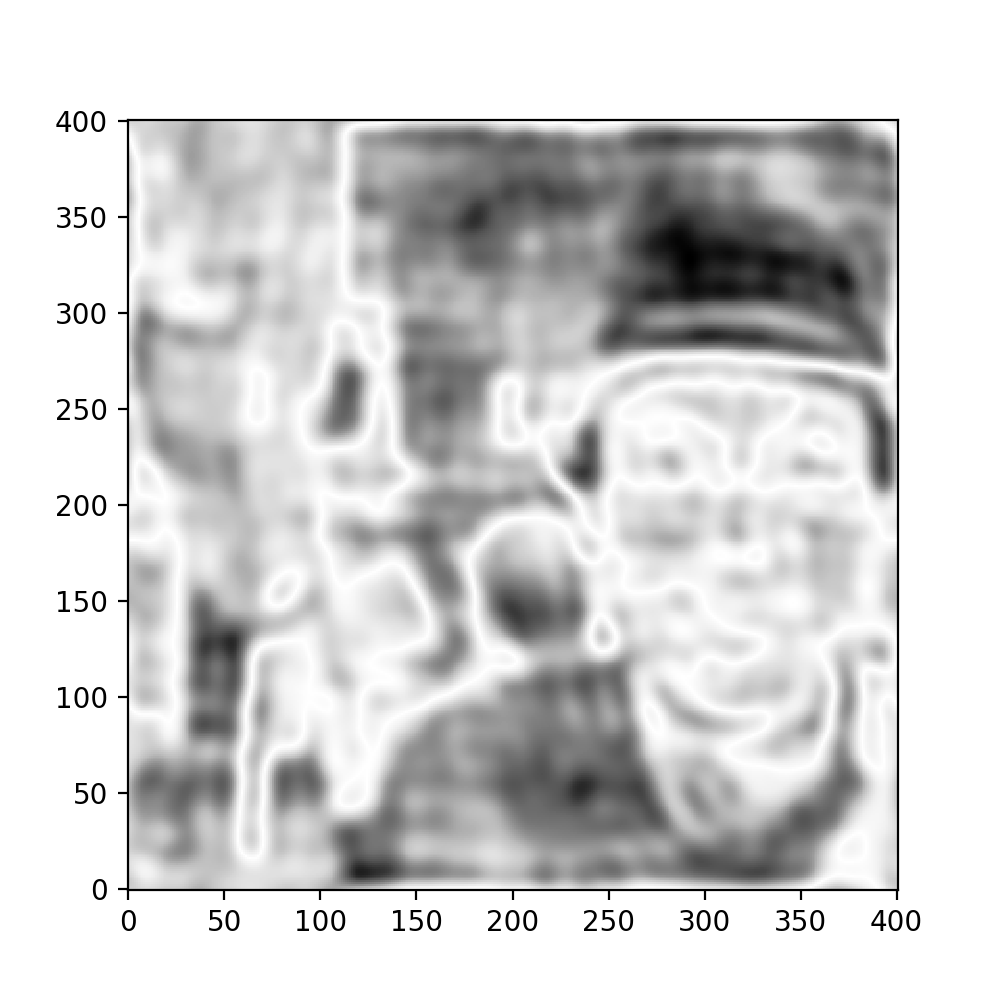

In [65]:
newim = np.fft.fftshift(np.fft.ifft2((obs_uv_matrix * ft)))
fig,ax = plt.subplots(figsize=(5,5))
ax.imshow(np.abs(newim),origin='bottom', cmap='Greys')

/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


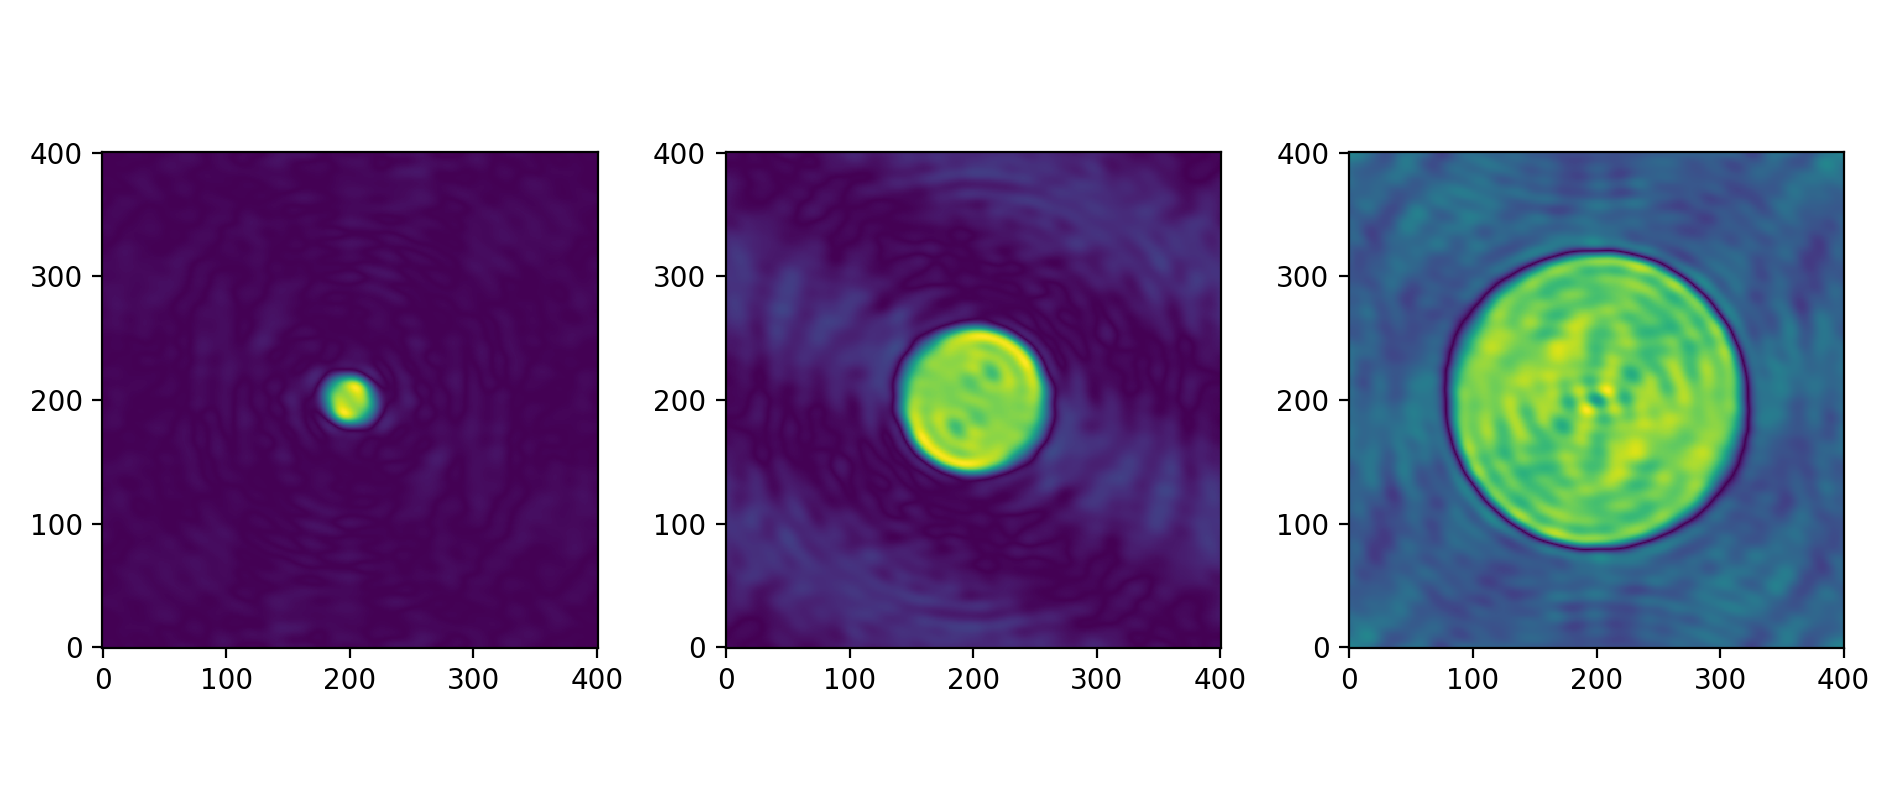

In [21]:
# observe the uniform disk example and see what we get back
# increasing the disk size causes the disk to be resolved out
fig,ax = plt.subplots(1,3,figsize=(9.5,4))
for i,radius in enumerate([20,60,120]):
    im = np.zeros((sz,sz))
    x = np.arange(sz) + 0.5 - sz/2.
    x, y = np.meshgrid(x,x)
    ok = np.where( (x**2 + y**2) < radius**2)
    im[ok] = 1
    ft = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(im)))
    newim = np.fft.fftshift(np.fft.ifft2((obs_uv_matrix * ft)))
    ax[i].imshow(np.abs(newim),origin='bottom')
    
fig.tight_layout()